<img src="https://github.com/rjpost20/Anomalous-Bank-Transactions-Detection-Project/blob/main/data/AdobeStock_319163865.jpeg?raw=true">
Image by <a href="https://stock.adobe.com/contributor/200768506/andsus?load_type=author&prev_url=detail" >AndSus</a> on Adobe Stock

# Phase 5 Project: *Detecting Anomalous Financial Transactions*

## Notebook 1: Intro, EDA and Preprocessing

### By Ryan Posternak

Flatiron School, Full-Time Live NYC<br>
Project Presentation Date: August 25th, 2022<br>
Instructor: Joseph Mata

## Goal: Build a model for FinCEN that can accurately identify anomalous financial transactions, as measured by area under the precision-recall curve (AUPRC)

*This is a project for learning purposes. FinCEN is not involved with this project in any way.*

<br>

# Overview and Business Understanding

<br>

# Data Understanding

<br>

# Imports, Reading in Data, and Exploratory Data Analysis

### Google colab compatibility downloads

In [ ]:
!sudo apt update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://dlcdn.apache.org/spark/spark-3.3.0/spark-3.3.0-bin-hadoop3.tgz 
!tar xf spark-3.3.0-bin-hadoop3.tgz
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.3.0-bin-hadoop3"
!pip install pyspark==3.3.0
!pip install -q findspark
import findspark
findspark.init()

In [1]:
# Connect to Google drive
from google.colab import drive, files
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Import libraries, packages and modules

In [2]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
from itertools import chain

from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.types import StringType, IntegerType, DoubleType, TimestampType
# from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler
# from pyspark.ml import Pipeline
# from pyspark.ml.classification import LogisticRegression
# from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
# from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit

# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

import matplotlib.pyplot as plt
plt.style.use('seaborn')
import seaborn as sns
from IPython.display import HTML, display
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [ ]:
helper_functions = files.upload()
from helper_functions import spark_resample

In [ ]:
# Check Colab GPU info
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Not connected to a GPU')
else:
    print(gpu_info)

In [ ]:
# Check Colab RAM info
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

In [3]:
# Set text to wrap in Google colab notebook
def set_css():
    display(HTML('''
    <style>
      pre {
          white-space: pre-wrap;
      }
    </style>
    '''))
get_ipython().events.register('pre_run_cell', set_css)

In [4]:
# Initialize Spark Session
spark = SparkSession.builder\
        .master("local[*]")\
        .appName("Colab")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()

spark

### Description of Features

**Dataset 1 – Transactions:**

`MessageId` - Globally unique identifier within this dataset for individual transactions<br>
`UETR` - The Unique End-to-end Transaction Reference—a 36-character string enabling traceability of all individual transactions associated with a single end-to-end transaction<br>
`TransactionReference` - Unique identifier for an individual transaction<br>
`Timestamp` - Time at which the individual transaction was initiated<br>
`Sender` - Institution (bank) initiating/sending the individual transaction<br>
`Receiver` - Institution (bank) receiving the individual transaction<br>
`OrderingAccount` - Account identifier for the originating ordering entity (individual or organization) for end-to-end transaction<br>
`OrderingName` - Name for the originating ordering entity<br>
`OrderingStreet` - Street address for the originating ordering entity<br>
`OrderingCountryCityZip` - Remaining address details for the originating ordering entity<br>
`BeneficiaryAccount` - Account identifier for the final beneficiary entity (individual or organization) for end-to-end transaction<br>
`BeneficiaryName` - Name for the final beneficiary entity<br>
`BeneficiaryStreet` - Street address for the final beneficiary entity<br>
`BeneficiaryCountryCityZip` - Remaining address details for the final beneficiary entity<br>
`SettlementDate` - Date the individual transaction was settled<br>
`SettlementCurrency` - Currency used for transaction<br>
`SettlementAmount` - Value of the transaction net of fees/transfer charges/forex<br>
`InstructedCurrency` - Currency of the individual transaction as instructed to be paid by the Sender<br>
`InstructedAmount` - Value of the individual transaction as instructed to be paid by the Sender<br>
`Label` - Boolean indicator of whether the transaction is anomalous or not. This is the target variable for the prediction task.<br>
<br>
**Dataset 2 – Banks:**

`Bank` - Identifier for the bank<br>
`Account` - Identifier for the account<br>
`Name` - Name of the account<br>
`Street` - Street address associated with the account<br>
`CountryCityZip` - Remaining address details associated with the account<br>
`Flags` - Enumerated data type indicating potential issues or special features that have been associated with an account. Flag definitions are below:<br>
00 - No flags<br>
01 - Account closed<br>
03 - Account recently opened<br>
04 - Name mismatch<br>
05 - Account under monitoring<br>
06 - Account suspended<br>
07 - Account frozen<br>
08 - Non-transaction account<br>
09 - Beneficiary deceased<br>
10 - Invalid company ID<br>
11 - Invalid individual ID<br>
<br>
Additional information from data providers:<br>
"Because each end-to-end transaction is defined by one originating orderer and one final beneficiary, the `OrderingAccount` and `BeneficiaryAccount` in a given row may not necessarily belong to the bank in that row's `Sender` and the bank in that row's `Receiver`, respectively. The correct way to associate an `OrderingAccount` to the correct bank is to identify the `Sender` bank in the originating (first) individual transaction in that end-to-end transaction, and the correct way to associate a `BeneficiaryAccount` to the correct bank is to identify the `Receiver` bank in the final (last) individual transaction in that end-to-end transaction."

## Read in Data

In [5]:
# Read in transactions training and testing data csv files to Spark DataFrames
train_df = spark.read.csv('/content/drive/MyDrive/Colab Notebooks/transaction_train_dataset.csv', header=True, inferSchema=True)
test_df = spark.read.csv('/content/drive/MyDrive/Colab Notebooks/transaction_test_dataset.csv', header=True, inferSchema=True)

# Read in banks data csv file to a Spark DataFrame
banks_df = spark.read.csv('/content/drive/MyDrive/Colab Notebooks/bank_dataset.csv', header=True, inferSchema=True)

<br>

## Preliminary EDA

In [6]:
# Print shape of dataframes
print(f"train_df:  {train_df.count():,} Rows, {len(train_df.columns)} Columns")
print(f"test_df:  {test_df.count():,} Rows, {len(test_df.columns)} Columns")
print(f"banks_df:  {banks_df.count():,} Rows, {len(banks_df.columns)} Columns")

train_df:  4,691,725 Rows, 20 Columns
test_df:  705,108 Rows, 20 Columns
banks_df:  527,503 Rows, 6 Columns


In [ ]:
# Print schema of train_df dataframe
train_df.printSchema()

In [ ]:
# Print schema of banks_df dataframe
banks_df.printSchema()

In [ ]:
# Display first row of train_df
train_df.show(n=1, truncate=False, vertical=True)

In [ ]:
# Display first 5 rows of banks dataframe
banks_df.show(5, False)

In [ ]:
# Print number of unique values in each column of train_df; sample 1% of dataframe for efficiency
train_df_unique = train_df.sample(False, 0.01).agg(*(F.countDistinct(F.col(c)).alias(c) for c in train_df.columns))
total_rows = train_df_unique.collect()[0]['MessageId']

print(f"Number of unique values per column (in sample of 1% of dataframe):\n")
print(f"Total rows in sample: {total_rows}")
train_df_unique.show(truncate=False, vertical=True)

In [ ]:
# Print number of unique values in each column of banks_df
banks_df_unique = banks_df.agg(*(F.countDistinct(F.col(c)).alias(c) for c in banks_df.columns))

print(f"Number of unique values per column:\n")
print(f"Total rows: {banks_df.count()}")
banks_df_unique.show(truncate=False, vertical=True)

In [ ]:
# Print number of null/NaN values in each column of train_df
train_df_null = train_df.select([F.count(F.when(F.col(c).isNull() | F.isnan(c), c))\
                                 .alias(c) for c in train_df.columns if c != 'Timestamp'])

print('Number of null/NaN values per column:\n')
train_df_null.show(truncate=False, vertical=True)

In [ ]:
# # Print number of null/NaN values in each column of banks_df
banks_df_null = banks_df.select([F.count(F.when(F.col(c).isNull() | F.isnan(c), c))\
                                 .alias(c) for c in banks_df.columns])

print('Number of null/NaN values per column:\n')
banks_df_null.show(truncate=False, vertical=True)

In [ ]:
# Display summary statistics table of numeric columns in transactions dataframe
num_cols = [item[0] for item in train_df.dtypes if item[1] == 'int' or item[1] == 'double']

train_df.select(num_cols).summary().show(truncate=False)

In [ ]:
# Display value counts for 'Flags' feature of banks_df
flag_counts = banks_df.groupBy('Flags').count()

# Create list of accounts with non-zero flags in banks_df
non_zero_accounts = []
for row in banks_df.filter(banks_df.Flags != 0).collect()[:]:
    non_zero_accounts.append(row['Account'])

# Count occurences of ordering accounts associated with non-zero flags in training data
transactions_ordering_flagged_train = train_df.where(F.col('OrderingAccount').isin(non_zero_accounts)).count()
# Count occurences of beneficiary accounts associated with non-zero flags in training data
transactions_beneficiary_flagged_train = train_df.where(F.col('BeneficiaryAccount').isin(non_zero_accounts)).count()
# Count occurences of ordering accounts associated with non-zero flags in testing data
transactions_ordering_flagged_test = test_df.where(F.col('OrderingAccount').isin(non_zero_accounts)).count()
# Count occurences of beneficiary accounts associated with non-zero flags in testing data
transactions_beneficiary_flagged_test = test_df.where(F.col('BeneficiaryAccount').isin(non_zero_accounts)).count()

print(f"Accounts with non-zero flags: {len(non_zero_accounts)}\n")
print(f"Transactions with non-zero flag associated with OrderingAccount (train): {transactions_ordering_flagged_train}")
print(f"Transactions with non-zero flag associated with BeneficiaryAccount (train): {transactions_beneficiary_flagged_train}\n")
print(f"Transactions with non-zero flag associated with OrderingAccount (test): {transactions_ordering_flagged_test}")
print(f"Transactions with non-zero flag associated with BeneficiaryAccount (test): {transactions_beneficiary_flagged_test}\n")
print('Value counts of Flags feature of banks_df:\n')
flag_counts.show(truncate=False)

In [ ]:
# Display value counts for 'Label' column (classification target) in train_df
class_counts = train_df.groupBy('Label').count().withColumn('percent', F.col('count')/train_df.count())

class_counts.show(truncate=10)

**Remarks:**
- This is an extremely imbalanced dataset - only about 0.1% of the data is in the positive class. We will need to address this class imbalance as part of the modeling process.

<br>

In [7]:
# Sample 5% of train_df for visualizations (approximately 235k observations) for efficiency
viz_cols = ['Sender', 'Receiver', 'InstructedCurrency', 'SettlementCurrency', 'Label']
viz_df = train_df.select(viz_cols).sample(withReplacement=False, fraction=0.05, seed=42).toPandas()

### Visualize target class distributions of sender and receiver banks used in transactions

In [ ]:
# Display unique senders in training dataset
print(f"train_df, {train_df.select('Sender').distinct().count()} unique senders:")
train_df.select('Sender').distinct().show(5)

In [ ]:
# Display unique senders in training dataset where transaction is anomalous
unique_anom_senders_count = train_df.filter(train_df.Label == 1)\
                                    .select('Sender').distinct().count()

print(f"train_df, {unique_anom_senders_count} unique senders among anomalous transactions:")
train_df.filter(train_df.Label == 1).select('Sender').distinct().show(5)

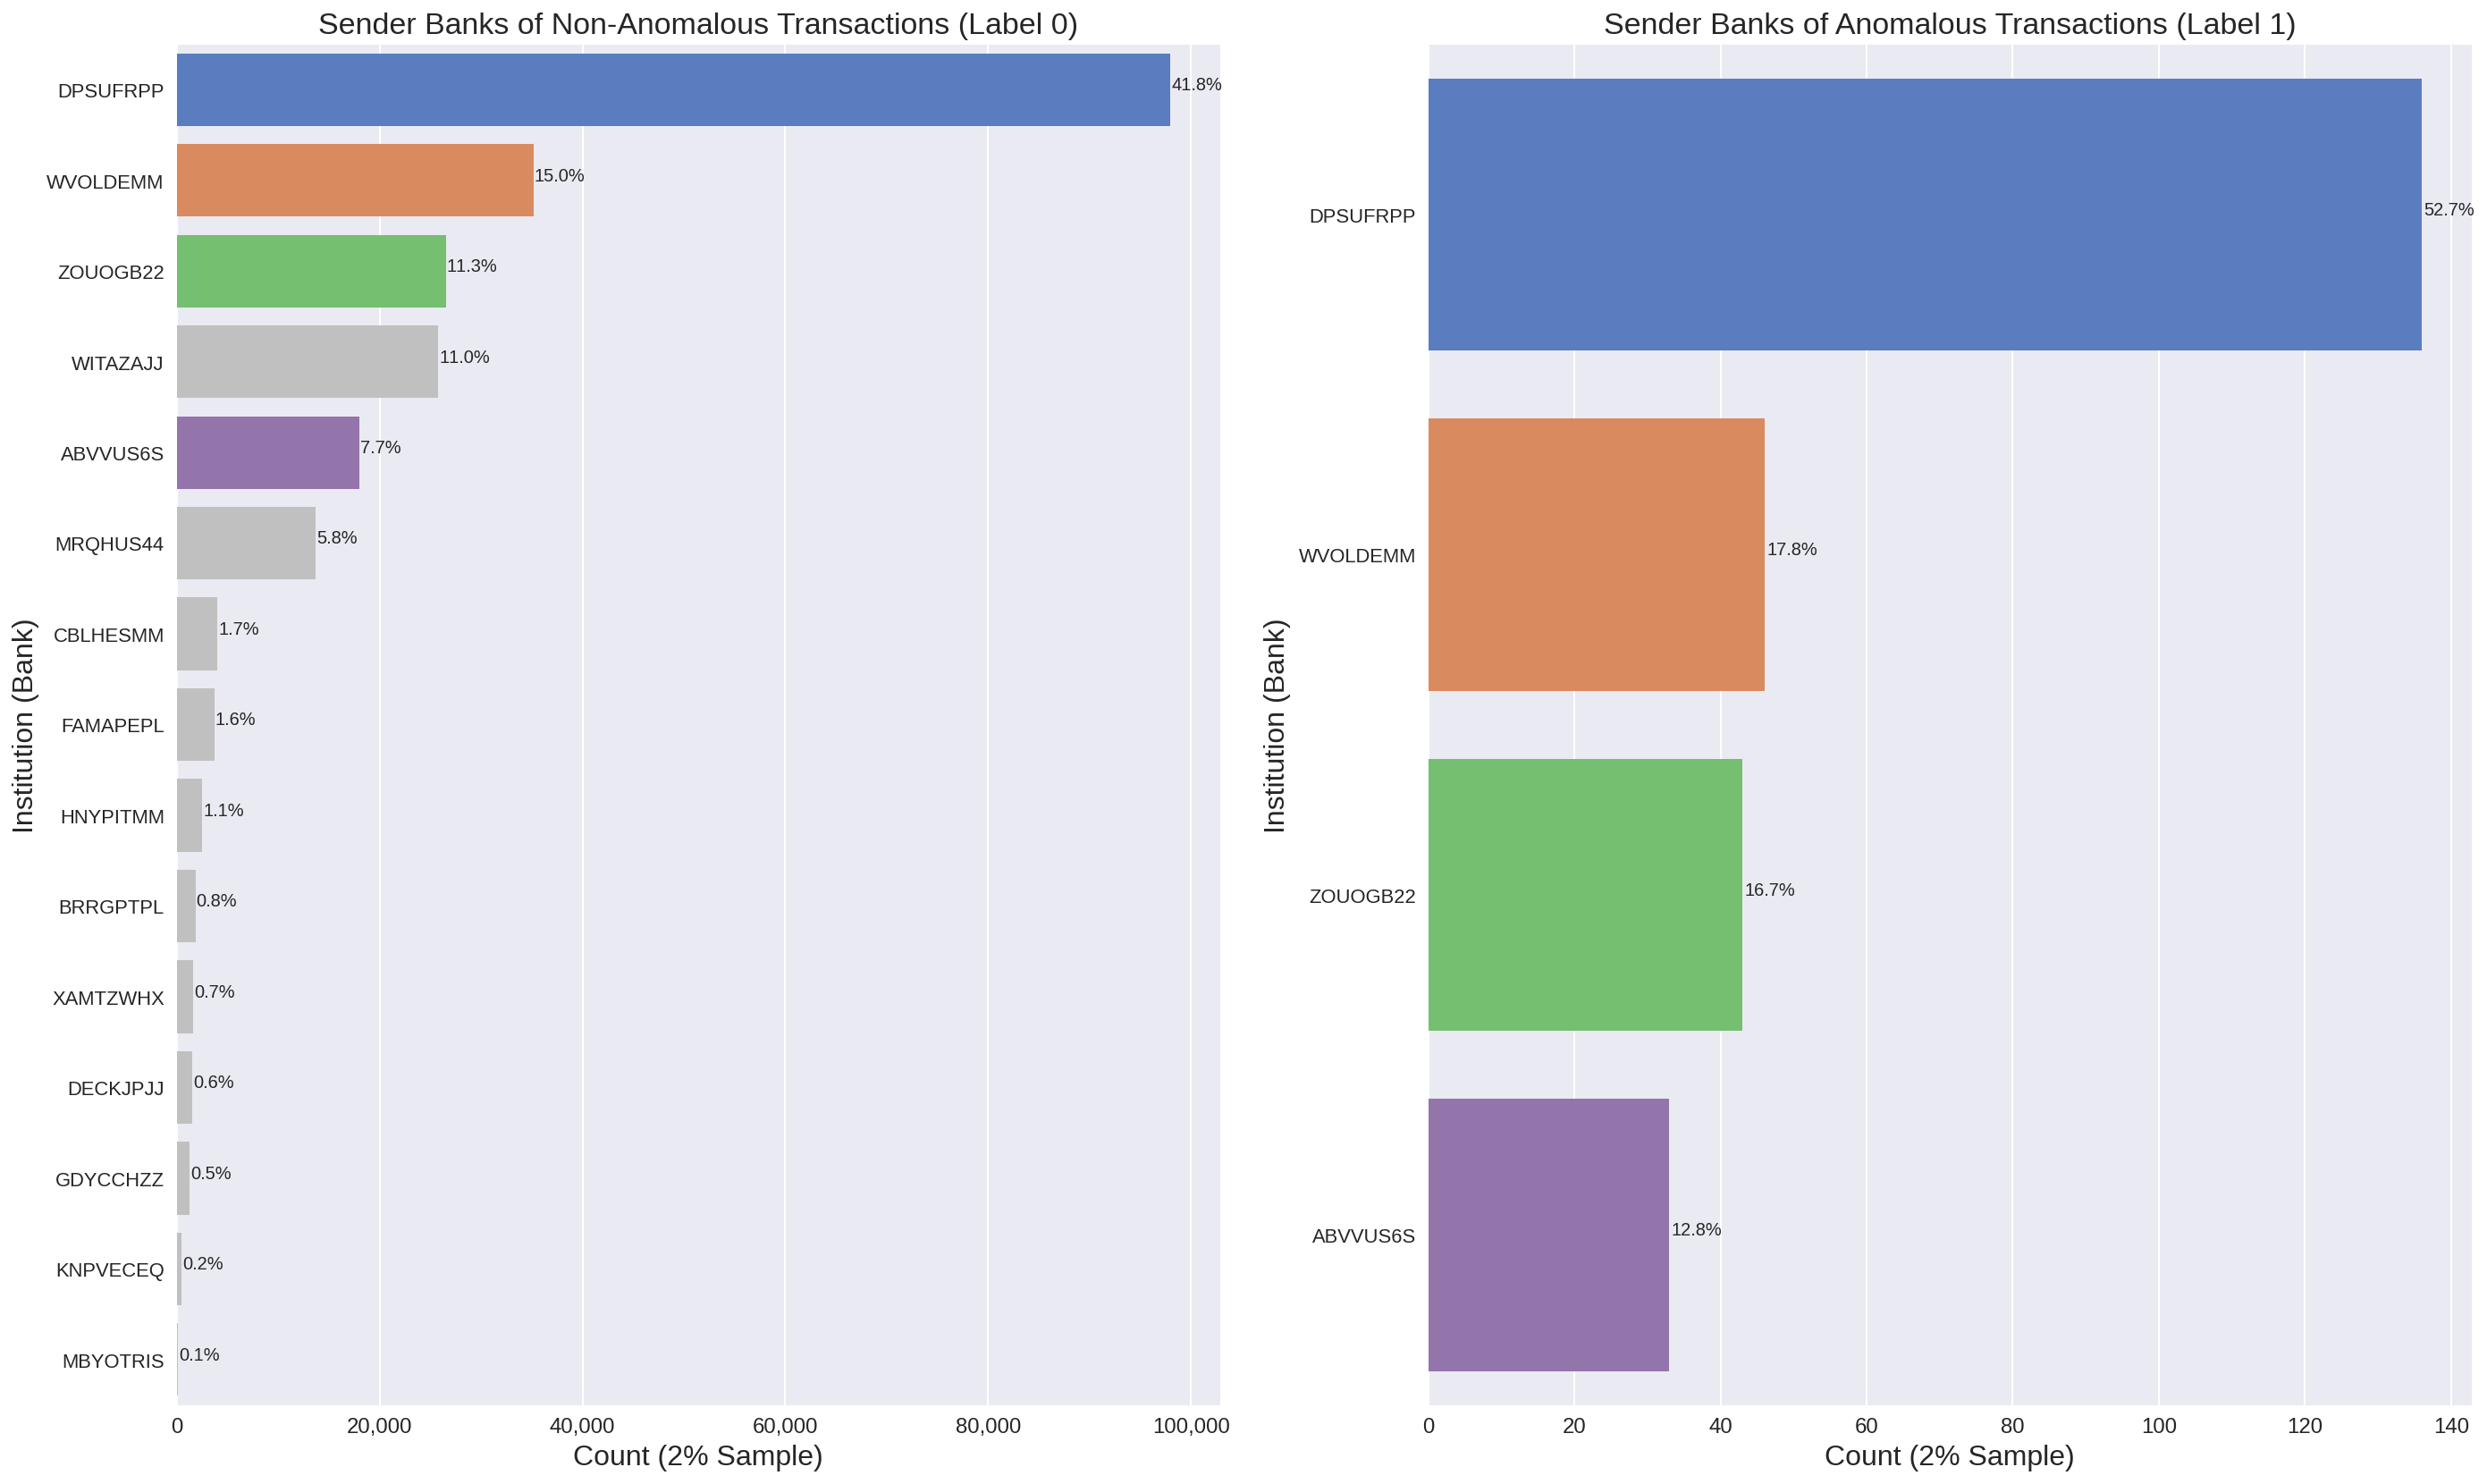

In [13]:
# Define figure and axes
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(23, 14))

# Set consistent color palette where y-axis values in both axes, otherwise silver
palette = sns.color_palette('muted', as_cmap=True)*2
palette_map = {}
for val, color in zip(viz_df['Sender'].value_counts().index, palette):
    if val in viz_df[viz_df.Label == 0]['Sender'].value_counts().index \
    and val in viz_df[viz_df.Label == 1]['Sender'].value_counts().index:
        palette_map[val] = color
    else:
        palette_map[val]= 'silver'

# Plot countplot of non-anomalous transactions
sns.countplot(y='Sender', data=viz_df[viz_df.Label == 0], ax=ax1, palette=palette_map, 
              order=viz_df[viz_df.Label == 0]['Sender'].value_counts().index) # Order descending

# Plot countplot of anomalous transactions
sns.countplot(y='Sender', data=viz_df[viz_df.Label == 1], ax=ax2, palette=palette_map, 
              order=viz_df[viz_df.Label == 1]['Sender'].value_counts().index) # Order descending

# Print percentages to the right of bars (ax1)
for p in ax1.patches:
    percentage = '{:.1f}%'.format(100 * p.get_width()/viz_df[viz_df.Label == 0].shape[0])
    x = p.get_x() + p.get_width()+100
    y = p.get_y() + p.get_height()/2
    ax1.annotate(percentage, (x, y))

# Print percentages to the right of bars (ax2)
for p in ax2.patches:
    percentage = '{:.1f}%'.format(100 * p.get_width()/viz_df[viz_df.Label == 1].shape[0])
    x = p.get_x() + p.get_width()+0.3
    y = p.get_y() + p.get_height()/2
    ax2.annotate(percentage, (x, y))

ax1.set_title('Sender Banks of Non-Anomalous Transactions (Label 0)', fontsize=17)
ax1.set_xlabel('Count (2% Sample)', fontsize=16)
ax1.set_xticklabels(['{:,}'.format(int(x)) for x in ax1.get_xticks()], fontsize=12)
ax1.set_ylabel('Institution (Bank)', fontsize=16)
ax1.set_yticklabels(ax1.get_yticklabels(), fontsize=11)
ax2.set_title('Sender Banks of Anomalous Transactions (Label 1)', fontsize=17)
ax2.set_xlabel('Count (2% Sample)', fontsize=16)
ax2.set_xticklabels(ax2.get_xticks().astype(int), fontsize=12)
ax2.set_ylabel('Institution (Bank)', fontsize=16)
ax2.set_yticklabels(ax2.get_yticklabels(), fontsize=11);

In [18]:
# Display unique receivers in training dataset
print(f"train_df, {train_df.select('Receiver').distinct().count()} unique receivers:")
train_df.select('Receiver').distinct().show(5)

train_df, 27 unique receivers:
+--------+
|Receiver|
+--------+
|WOEBDOSD|
|ZOUOGB22|
|BRRGPTPL|
|IHJTNL2A|
|GDYCCHZZ|
+--------+
only showing top 5 rows



In [ ]:
# Display unique receivers in training dataset where transaction is anomalous
unique_anom_receivers_count = train_df.filter(train_df.Label == 1)\
                                      .select('Receiver').distinct().count()

print(f"train_df, {unique_anom_receivers_count} unique receivers among anomalous transactions:")
train_df.filter(train_df.Label == 1).select('Receiver').distinct().show(5)

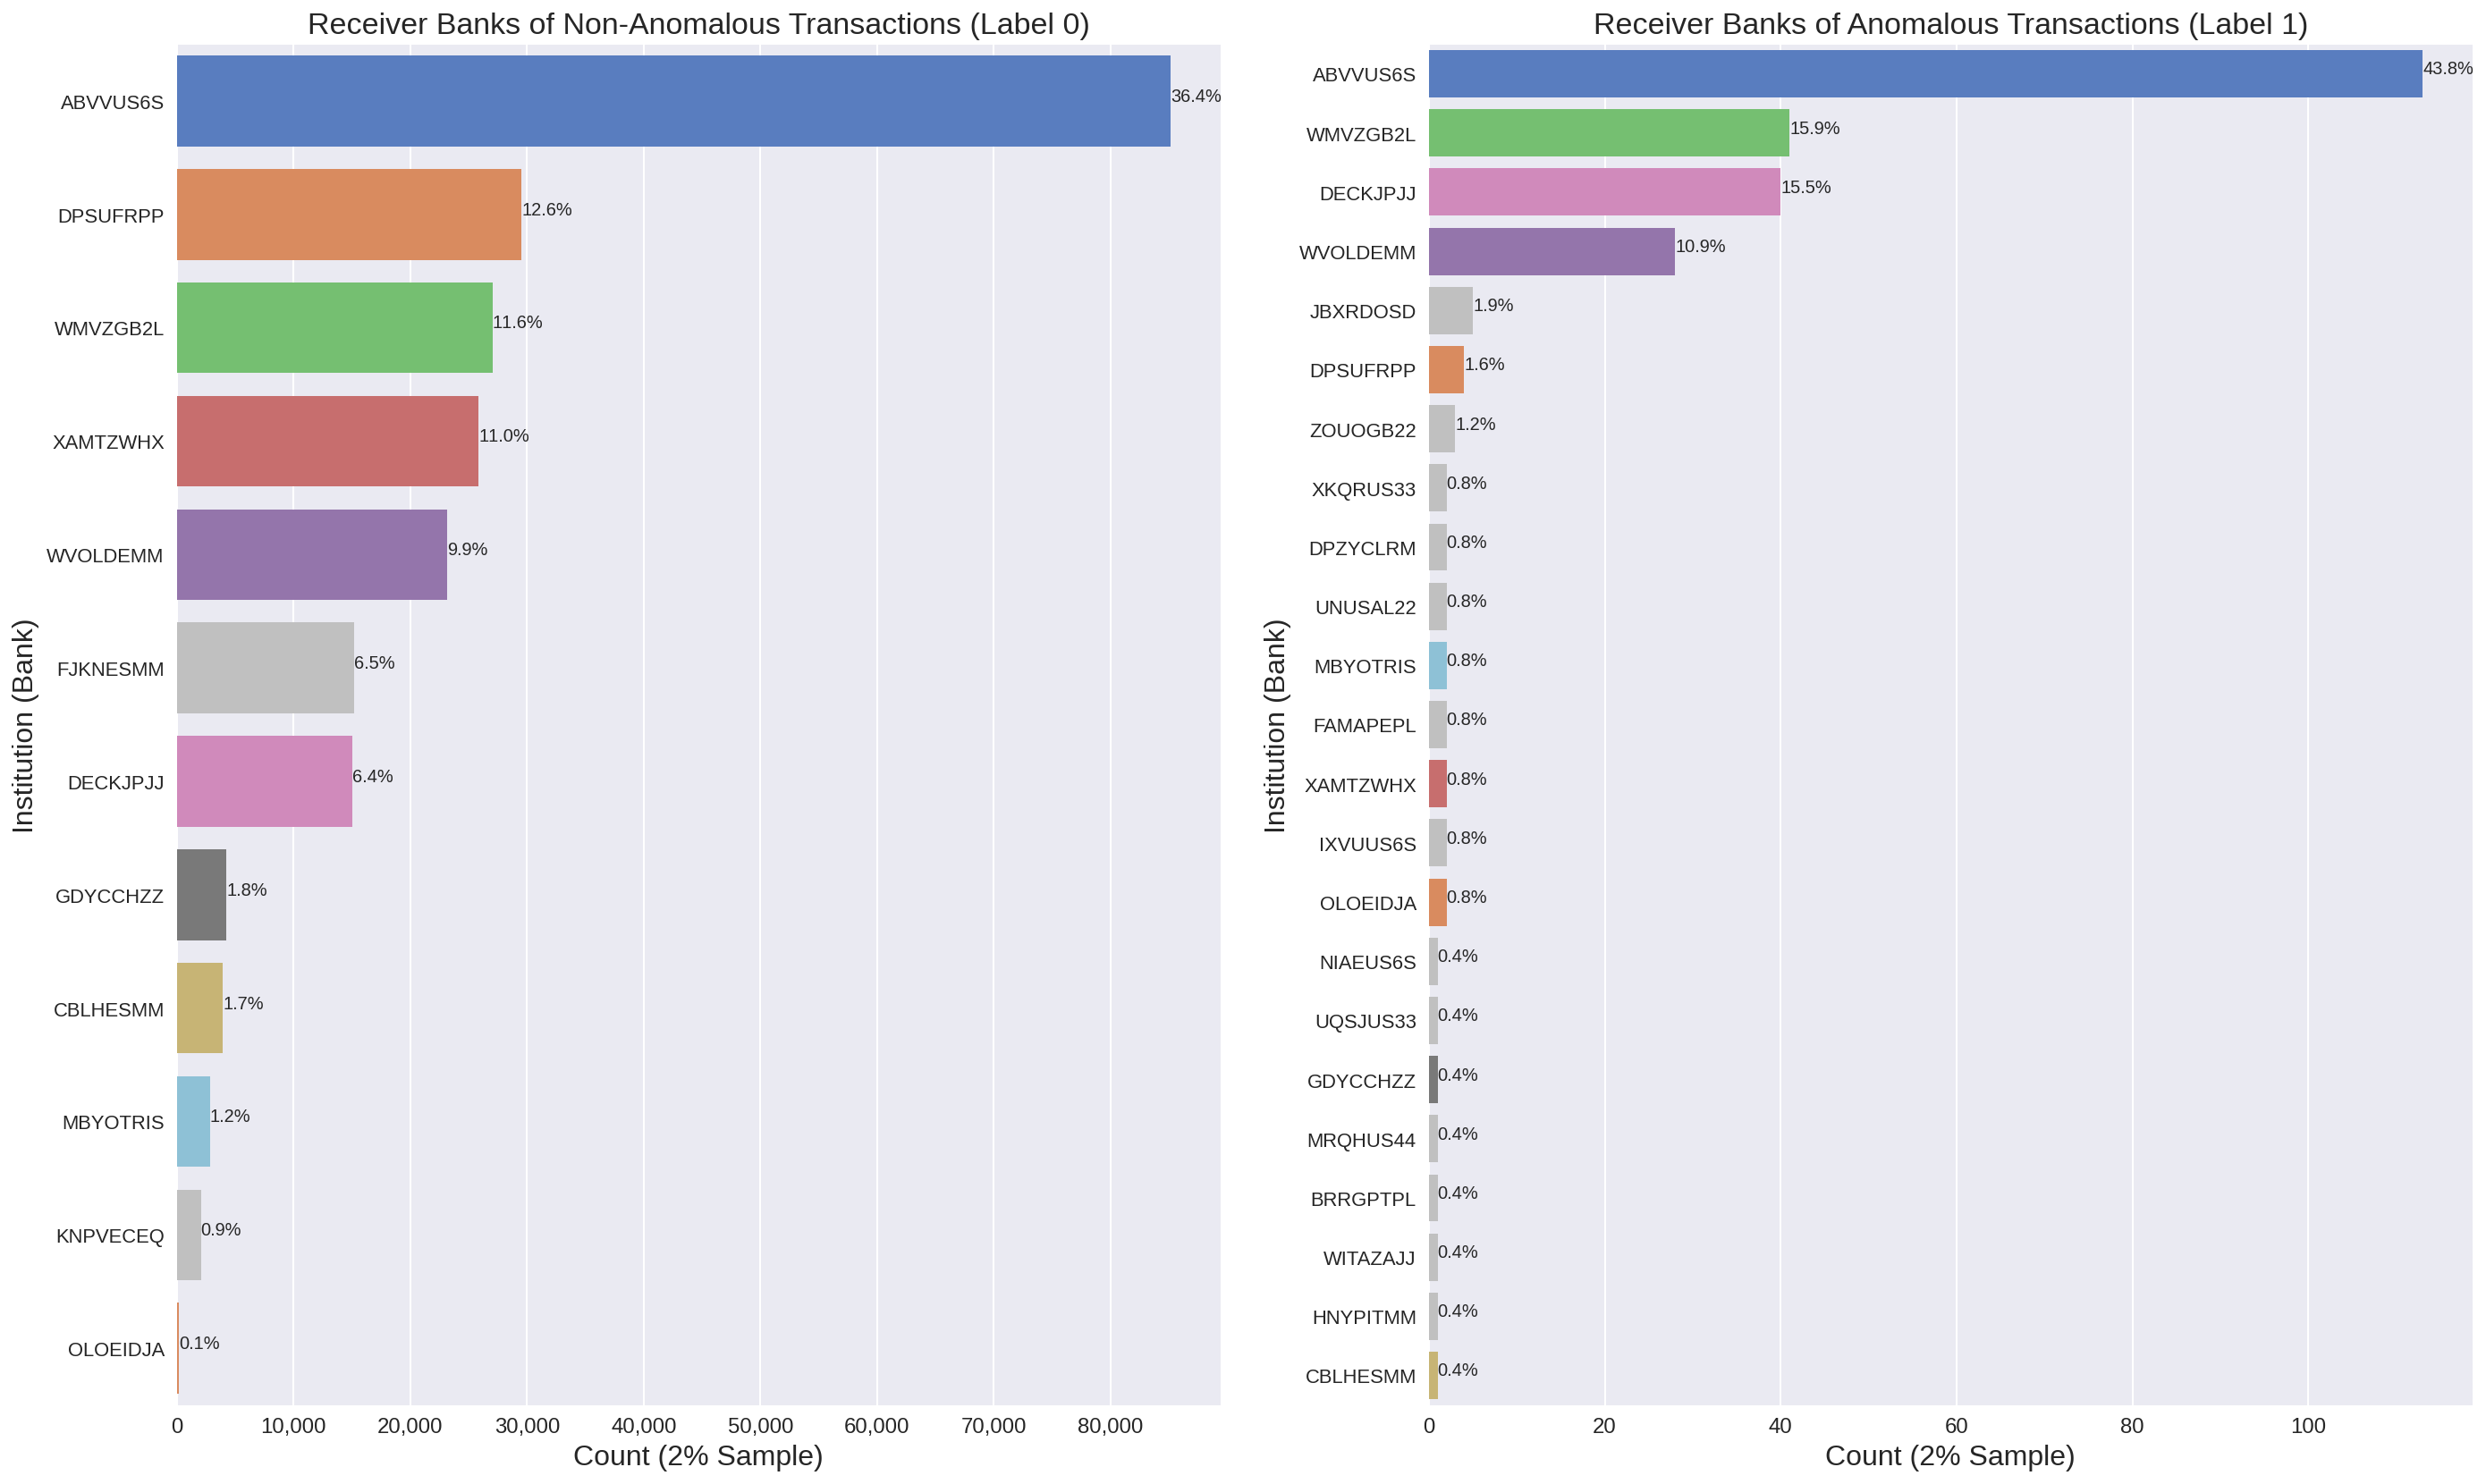

In [17]:
# Define figure and axes
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(23, 14))

# Set consistent color palette where y-axis values in both axes, otherwise silver
palette = sns.color_palette('muted', as_cmap=True)*3
palette_map = {}
for val, color in zip(viz_df['Receiver'].value_counts().index, palette):
    if val in viz_df[viz_df.Label == 0]['Receiver'].value_counts().index \
    and val in viz_df[viz_df.Label == 1]['Receiver'].value_counts().index:
        palette_map[val] = color
    else:
        palette_map[val]= 'silver'

# Plot countplot of non-anomalous transactions
ax1_plot = sns.countplot(y='Receiver', data=viz_df[viz_df.Label == 0], ax=ax1, palette=palette_map, 
              order=viz_df[viz_df.Label == 0]['Receiver'].value_counts().index)  # Order descending

# Update palette_map with values not found above
for val, color in zip(viz_df[viz_df.Label == 1]['Receiver'].value_counts().index, palette):
    if val not in palette_map:
        palette_map[val] = 'silver'  # Assign values not found above to silver


# Plot countplot of anomalous transactions
ax2_plot = sns.countplot(y='Receiver', data=viz_df[viz_df.Label == 1], ax=ax2, palette=palette_map, 
              order=viz_df[viz_df.Label == 1]['Receiver'].value_counts().index)  # Order descending

# Print percentages to the right of bars (ax1)
for p in ax1.patches:
    percentage = '{:.1f}%'.format(100 * p.get_width()/viz_df[viz_df.Label == 0].shape[0])
    x = p.get_x() + p.get_width()
    y = p.get_y() + p.get_height()/2
    ax1.annotate(percentage, (x, y))

# Print percentages to the right of bars (ax2)
for p in ax2.patches:
    percentage = '{:.1f}%'.format(100 * p.get_width()/viz_df[viz_df.Label == 1].shape[0])
    x = p.get_x() + p.get_width()
    y = p.get_y() + p.get_height()/2
    ax2.annotate(percentage, (x, y))

ax1.set_title('Receiver Banks of Non-Anomalous Transactions (Label 0)', fontsize=17)
ax1.set_xlabel('Count (2% Sample)', fontsize=16)
ax1.set_xticklabels(['{:,}'.format(int(x)) for x in ax1.get_xticks()], fontsize=12)
ax1.set_ylabel('Institution (Bank)', fontsize=16)
ax1.set_yticklabels(ax1.get_yticklabels(), fontsize=11)
ax2.set_title('Receiver Banks of Anomalous Transactions (Label 1)', fontsize=17)
ax2.set_xlabel('Count (2% Sample)', fontsize=16)
ax2.set_xticklabels(ax2.get_xticks().astype(int), fontsize=12)
ax2.set_ylabel('Institution (Bank)', fontsize=16)
ax2.set_yticklabels(ax2.get_yticklabels(), fontsize=11);

**Remarks:**
- It looks like the choice of sender bank is very informative in terms of determining whether a transaction is anomalous or not, while the choice of receiver bank is not nearly as valuable.
- Only 4 out of 16 sender banks tend to be utilized in anomalous transactions, while many more are utilized in non-anomalous transactions.
- Looking at receiver banks, 12 out of 16 tend to be utilized for non-anomalous transactions, while nearly all are utilized in anomalous transactions (though 4 are by far most common).
- It might be useful to engineer a feature or features in sender-receiver bank combinations, rather than just one or the other.

### Visualize target class distributions of instructed and settlement currencies used in transactions

In [ ]:
# Display unique instructed currencies used in transactions
print(f"train_df, {train_df.select('InstructedCurrency').distinct().count()} unique instructed currencies:")
train_df.select('InstructedCurrency').distinct().show()

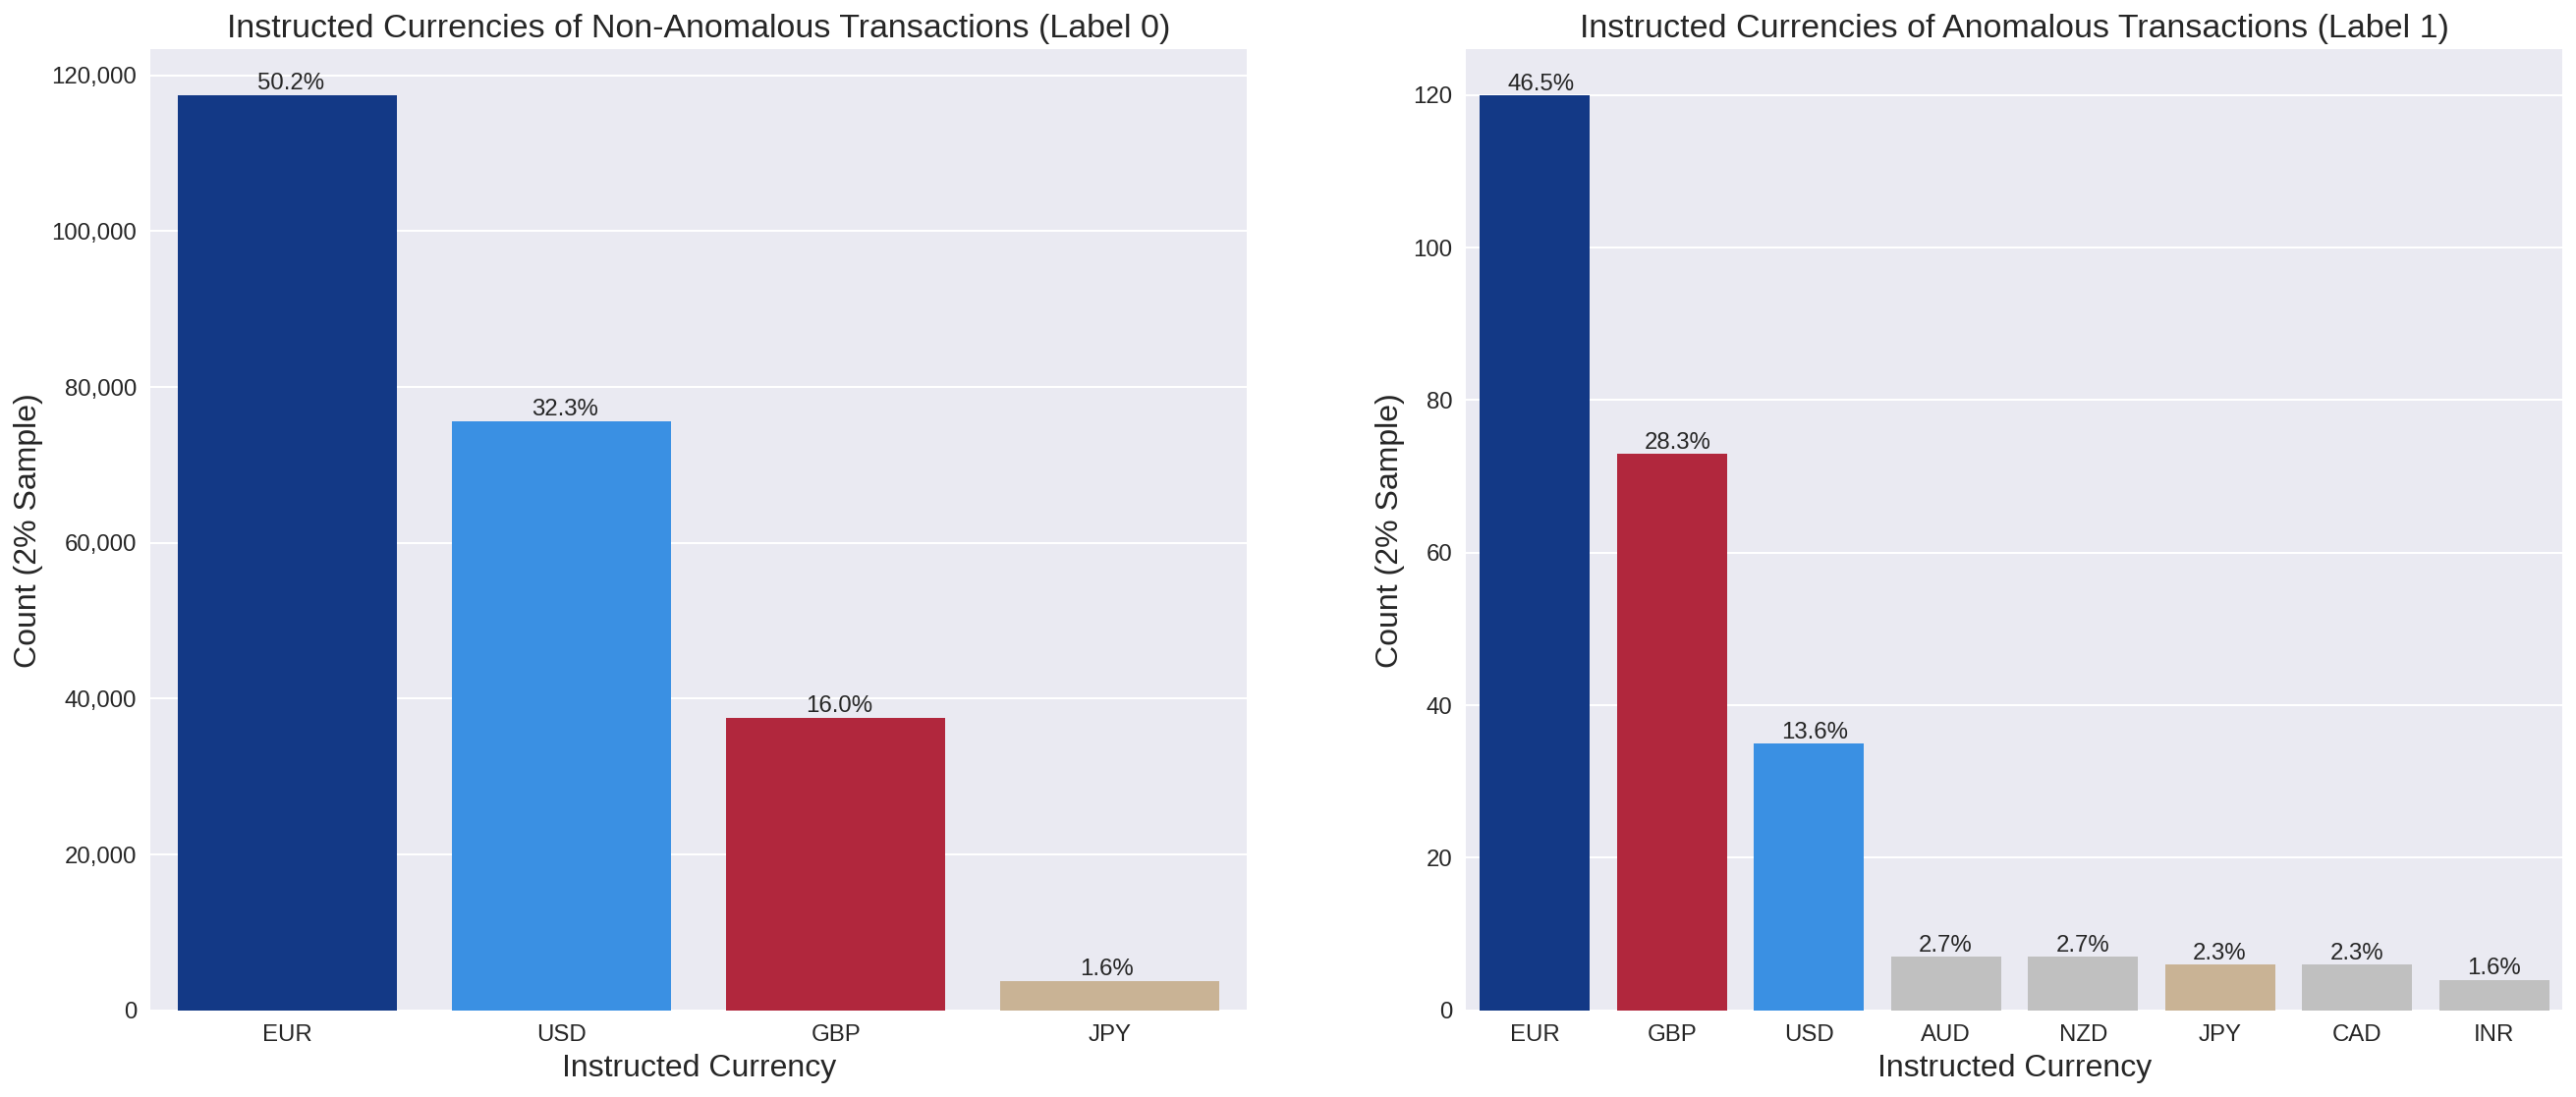

In [23]:
# Define figure and axes
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(22, 9))

# Set consistent color palette where x-axis values in both axes, otherwise silver
palette_map = {'USD': 'dodgerblue', 'EUR': '#003399', 'GBP':'#C8102E', 'JPY': 'tan'}
for val in viz_df[viz_df.Label == 1]['InstructedCurrency'].value_counts().index:
    if val not in viz_df[viz_df.Label == 0]['InstructedCurrency'].value_counts().index:
        palette_map[val] = 'silver'

# Plot countplot of non-anomalous transactions
sns.countplot(x='InstructedCurrency', data=viz_df[viz_df.Label == 0], ax=ax1, 
              order=viz_df[viz_df.Label == 0]['InstructedCurrency'].value_counts().index,  # Order descending
              palette=palette_map)

# Plot countplot of anomalous transactions
sns.countplot(x='InstructedCurrency', data=viz_df[viz_df.Label == 1], ax=ax2, 
              order=viz_df[viz_df.Label == 1]['InstructedCurrency'].value_counts().index,  # Order descending
              palette=palette_map)

# Print percentages on top of bars (ax1)
for p in ax1.patches:
    txt = str(round(p.get_height() / viz_df[viz_df.Label == 0].shape[0]*100, 1)) + '%'
    txt_x = p.get_x()+0.29
    txt_y = p.get_height()+800
    ax1.text(txt_x, txt_y, txt, fontsize=12)

# Print percentages on top of bars (ax2)
for p in ax2.patches:
    txt = str(round(p.get_height() / viz_df[viz_df.Label == 1].shape[0]*100, 1)) + '%'
    txt_x = p.get_x()+0.2
    txt_y = p.get_height()+0.7
    ax2.text(txt_x, txt_y, txt, fontsize=12)

ax1.set_title('Instructed Currencies of Non-Anomalous Transactions (Label 0)', fontsize=17)
ax1.set_xlabel('Instructed Currency', fontsize=16)
ax1.set_xticklabels(ax1.get_xticklabels(), fontsize=12)
ax1.set_ylabel('Count (2% Sample)', fontsize=16)
ax1.set_yticklabels(['{:,}'.format(int(x)) for x in ax1.get_yticks()], fontsize=12)
ax2.set_title('Instructed Currencies of Anomalous Transactions (Label 1)', fontsize=17)
ax2.set_xlabel('Instructed Currency', fontsize=16)
ax2.set_xticklabels(ax2.get_xticklabels(), fontsize=12)
ax2.set_ylabel('Count (2% Sample)', fontsize=16)
ax2.set_yticklabels(ax2.get_yticks().astype(int), fontsize=12);

In [ ]:
# Display unique settlement currencies used in transactions
print(f"train_df, {train_df.select('SettlementCurrency').distinct().count()} unique settlement currencies:")
train_df.select('SettlementCurrency').distinct().show()

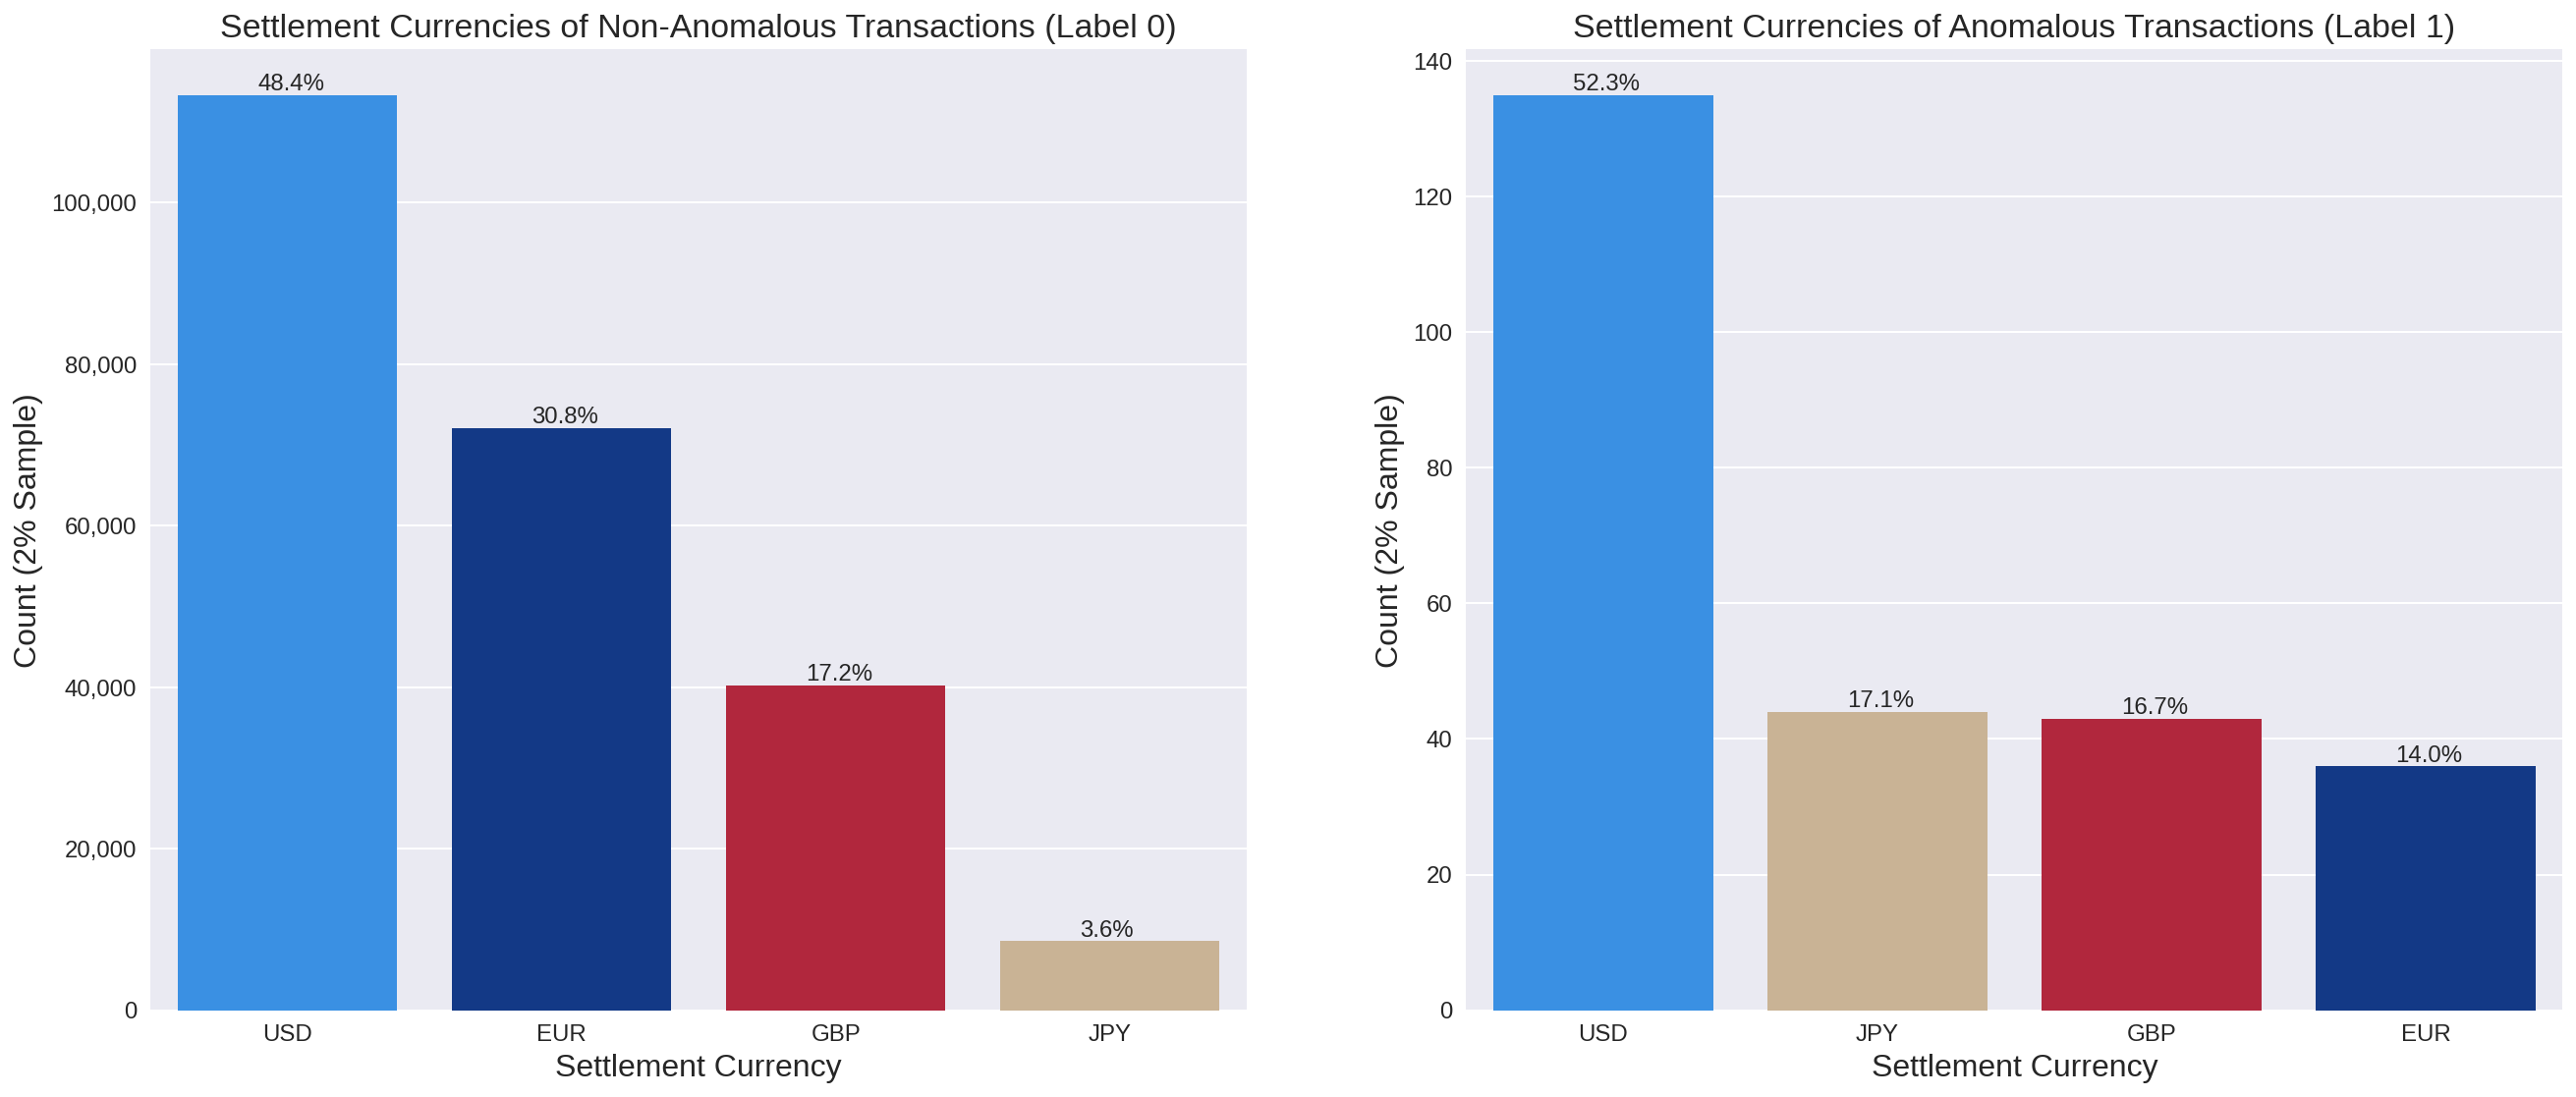

In [27]:
# Define figure and axes
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(22, 9))

# Set consistent color palette
palette_map = {'USD': 'dodgerblue', 'EUR': '#003399', 'GBP':'#C8102E', 'JPY': 'tan'}

# Plot countplot of non-anomalous transactions
sns.countplot(x='SettlementCurrency', data=viz_df[viz_df.Label == 0], ax=ax1, 
              order=viz_df[viz_df.Label == 0]['SettlementCurrency'].value_counts().index, # Order descending
              palette=palette_map)

# Plot countplot of anomalous transactions
sns.countplot(x='SettlementCurrency', data=viz_df[viz_df.Label == 1], ax=ax2, 
              order=viz_df[viz_df.Label == 1]['SettlementCurrency'].value_counts().index, # Order descending
              palette=palette_map)

# Print percentages on top of bars (ax1)
for p in ax1.patches:
    txt = str(round(p.get_height() / viz_df[viz_df.Label == 0].shape[0]*100, 1)) + '%'
    txt_x = p.get_x()+0.29
    txt_y = p.get_height()+600
    ax1.text(txt_x, txt_y, txt, fontsize=12)

# Print percentages on top of bars (ax2)
for p in ax2.patches:
    txt = str(round(p.get_height() / viz_df[viz_df.Label == 1].shape[0]*100, 1)) + '%'
    txt_x = p.get_x()+0.29
    txt_y = p.get_height()+0.7
    ax2.text(txt_x, txt_y, txt, fontsize=12)

ax1.set_title('Settlement Currencies of Non-Anomalous Transactions (Label 0)', fontsize=17)
ax1.set_xlabel('Settlement Currency', fontsize=16)
ax1.set_xticklabels(ax1.get_xticklabels(), fontsize=12)
ax1.set_ylabel('Count (2% Sample)', fontsize=16)
ax1.set_yticklabels(['{:,}'.format(int(x)) for x in ax1.get_yticks()], fontsize=12)
ax2.set_title('Settlement Currencies of Anomalous Transactions (Label 1)', fontsize=17)
ax2.set_xlabel('Settlement Currency', fontsize=16)
ax2.set_xticklabels(ax2.get_xticklabels(), fontsize=12)
ax2.set_ylabel('Count (2% Sample)', fontsize=16)
ax2.set_yticklabels(ax2.get_yticks().astype(int), fontsize=12);

**Remarks:**
- Instructed currencies seems to be more informative in terms of being correlated with whether or not a transaction is anomalous.
- Among instructed currencies, we see the opposite trend as we saw with chosen banks; anomalous transactions tend to use a broader selection of instructed currencies, rather than a more narrow selection as we saw with chosen sender banks.
- Among settlement currencies, we see the same four currencies being utilized among both target classes, but in slightly different frequencies.
- We will keep the instructed currencies (and one hot encode them) as a feature in the final dataset and drop the settlement currencies.

<br>

# Preprocessing & Feature Engineering

Steps:
1. Create `OrderingCountry` and `BeneficiaryCountry` features
1. Create `InstructedAmountUSD` feature by converting all currencies in `InstructedAmount` to USD-scale
2. Create `IntermediaryTransactions` feature
3. Create `OriginalSender` and `FinalReceiver` features
4. Create `Flagged` feature by joining `Flags` column of `banks_df`
5. Create `SenderHourFreq` feature
6. Create `SenderCurrencyFreq` and `SenderCurrencyAmtAvg` features
7. Create `SenderReceiverFreq` feature

## Create `OrderingCountry` and `BeneficiaryCountry` features

In [28]:
# Split the content of OrderingCountryCityZip and BeneficiaryCountryCityZip on the forward-slash character ('/')
split_cols_ordering_train = F.split(train_df['OrderingCountryCityZip'], '/')
split_cols_beneficiary_train = F.split(train_df['BeneficiaryCountryCityZip'], '/')

# Add the OrderingCountry as a column to train_df and test_df
train_df = train_df.withColumn('OrderingCountry', split_cols_ordering_train.getItem(0))
train_df = train_df.withColumn('BeneficiaryCountry', split_cols_beneficiary_train.getItem(0))

# Repeat for test_df
split_cols_ordering_test = F.split(test_df['OrderingCountryCityZip'], '/')
split_cols_beneficiary_test = F.split(test_df['BeneficiaryCountryCityZip'], '/')
test_df = test_df.withColumn('OrderingCountry', split_cols_ordering_test.getItem(0))
test_df = test_df.withColumn('BeneficiaryCountry', split_cols_beneficiary_test.getItem(0))

### Accuracy check

In [ ]:
# Retrieve three random UETR codes
sample = train_df.sample(False, 0.00001).limit(3).collect()
UETRs = [sample[row]['UETR'] for row in range(3)]

# Only show relevant columns
cols_to_show = ['UETR', 'OrderingCountryCityZip', 'OrderingCountry', 'BeneficiaryCountryCityZip', 'BeneficiaryCountry']

# Preview transactions
train_df.filter(train_df.UETR.isin(UETRs)).select(cols_to_show).show(truncate=False)

In [ ]:
# Display value counts for new 'OrderingCountry' and 'BeneficiaryCountry' features of train_df
ordering_country_counts = train_df.groupBy('OrderingCountry').count().withColumn('percent', F.col('count')/train_df.count())
beneficiary_country_counts = train_df.groupBy('BeneficiaryCountry').count().withColumn('percent', F.col('count')/train_df.count())

ordering_country_counts.show(28, truncate=False)
beneficiary_country_counts.show(truncate=False)

**Remarks:**
- It looks like there are some rows with incorrect/unusual values, but for most of them it looks pretty obvious what the intended value was supposed to be. A couple are a bit ambiguous, e.g. 'E' in `OrderingCountries` could be either `DE`, `ES`, `EC` or `PE`. For these ones, we'll just impute the most frequent likely intended value.

In [29]:
# Replace incorrect/unusual ordering country values with most likely intended value
train_df = train_df.replace('F', 'FR', subset='OrderingCountry')
train_df = train_df.replace('GBS1 1TD', 'GB', subset='OrderingCountry')
train_df = train_df.replace('B', 'GB', subset='OrderingCountry')
train_df = train_df.replace('GBE5C 7TG', 'GB', subset='OrderingCountry')
train_df = train_df.replace('U', 'US', subset='OrderingCountry')
train_df = train_df.replace('D', 'DE', subset='OrderingCountry')
train_df = train_df.replace('R', 'FR', subset='OrderingCountry')
train_df = train_df.replace('GBBD6 2YA', 'GB', subset='OrderingCountry')
train_df = train_df.replace('E', 'ES', subset='OrderingCountry')
train_df = train_df.replace('FR46216 JOSEPH', 'FR', subset='OrderingCountry')
train_df = train_df.replace('FR97705 PEREIRA', 'FR', subset='OrderingCountry')
train_df = train_df.replace('G', 'GB', subset='OrderingCountry')
train_df = train_df.replace('S', 'US', subset='OrderingCountry')
train_df = train_df.replace('DE51111 WITTSTOCK', 'DE', subset='OrderingCountry')

# Replace incorrect/unusual beneficiary country values with most likely intended value
train_df = train_df.replace('E', 'ES', subset='BeneficiaryCountry')
train_df = train_df.replace('D', 'DE', subset='BeneficiaryCountry')
train_df = train_df.replace('USMACKENZIESTAD| KS 08333', 'US', subset='BeneficiaryCountry')
train_df = train_df.replace('USMICHAELVIEW| NH 97912', 'US', subset='BeneficiaryCountry')
train_df = train_df.replace('U', 'US', subset='BeneficiaryCountry')
train_df = train_df.replace('G', 'GB', subset='BeneficiaryCountry')
train_df = train_df.replace('USEMILYVIEW| KS 16890', 'US', subset='BeneficiaryCountry')
train_df = train_df.replace('USAGUILARSIDE| KY 08409', 'US', subset='BeneficiaryCountry')

# Display new value counts for 'OrderingCountry' and 'BeneficiaryCountry' features of train_df
ordering_country_counts = train_df.groupBy('OrderingCountry').count().withColumn('percent', F.col('count')/train_df.count())
beneficiary_country_counts = train_df.groupBy('BeneficiaryCountry').count().withColumn('percent', F.col('count')/train_df.count())

ordering_country_counts.show(truncate=False)
beneficiary_country_counts.show(truncate=False)

+---------------+-------+--------------------+
|OrderingCountry|count  |percent             |
+---------------+-------+--------------------+
|PT             |36690  |0.007820151436838263|
|GB             |529859 |0.11293479477164582 |
|DE             |603157 |0.12855762006511465 |
|ES             |80991  |0.017262520714662517|
|EC             |9547   |0.002034859246865492|
|TR             |2699   |5.752681582999856E-4|
|ZA             |514627 |0.10968822767745338 |
|US             |1002612|0.21369794691717864 |
|FR             |1621628|0.3456357736227081  |
|CH             |25027  |0.005334285364125135|
|IT             |49092  |0.010463528872642791|
|PE             |73733  |0.01571554172505848 |
|JP             |75057  |0.015997740703046322|
|ZW             |67006  |0.014281740724360443|
+---------------+-------+--------------------+

+------------------+-------+--------------------+
|BeneficiaryCountry|count  |percent             |
+------------------+-------+--------------------+
|ID

### Repeat for `test_df`

In [ ]:
# Display value counts for new 'OrderingCountry' and 'BeneficiaryCountry' features of test_df
ordering_country_counts = test_df.groupBy('OrderingCountry').count().withColumn('percent', F.col('count')/test_df.count())
beneficiary_country_counts = test_df.groupBy('BeneficiaryCountry').count().withColumn('percent', F.col('count')/test_df.count())

ordering_country_counts.show(28, truncate=False)
beneficiary_country_counts.show(truncate=False)

In [ ]:
# Replace incorrect/unusual ordering country values with most likely intended value
test_df = test_df.replace('F', 'FR', subset='OrderingCountry')
test_df = test_df.replace('R', 'FR', subset='OrderingCountry')
test_df = test_df.replace('D', 'DE', subset='OrderingCountry')
test_df = test_df.replace('S', 'US', subset='OrderingCountry')

# Replace incorrect/unusual beneficiary country values with most likely intended value
test_df = test_df.replace('U', 'US', subset='BeneficiaryCountry')
test_df = test_df.replace('USDPO AA 17341', 'US', subset='BeneficiaryCountry')
test_df = test_df.replace('USFPO AE 29185', 'US', subset='BeneficiaryCountry')
test_df = test_df.replace('S', 'US', subset='BeneficiaryCountry')

# Display new value counts for 'OrderingCountry' and 'BeneficiaryCountry' features of test_df
ordering_country_counts = test_df.groupBy('OrderingCountry').count().withColumn('percent', F.col('count')/test_df.count())
beneficiary_country_counts = test_df.groupBy('BeneficiaryCountry').count().withColumn('percent', F.col('count')/test_df.count())

ordering_country_counts.show(truncate=False)
beneficiary_country_counts.show(truncate=False)

### Visualize target class distributions or ordering countries and beneficiary countries of ordering and beneficiary entities

In [30]:
# Sample 5% of train_df for visualizations (approximately 235k observations) for efficiency
viz_cols = ['OrderingCountry', 'BeneficiaryCountry', 'Label']
viz_df = train_df.select(viz_cols).sample(withReplacement=False, fraction=0.05, seed=42).toPandas()

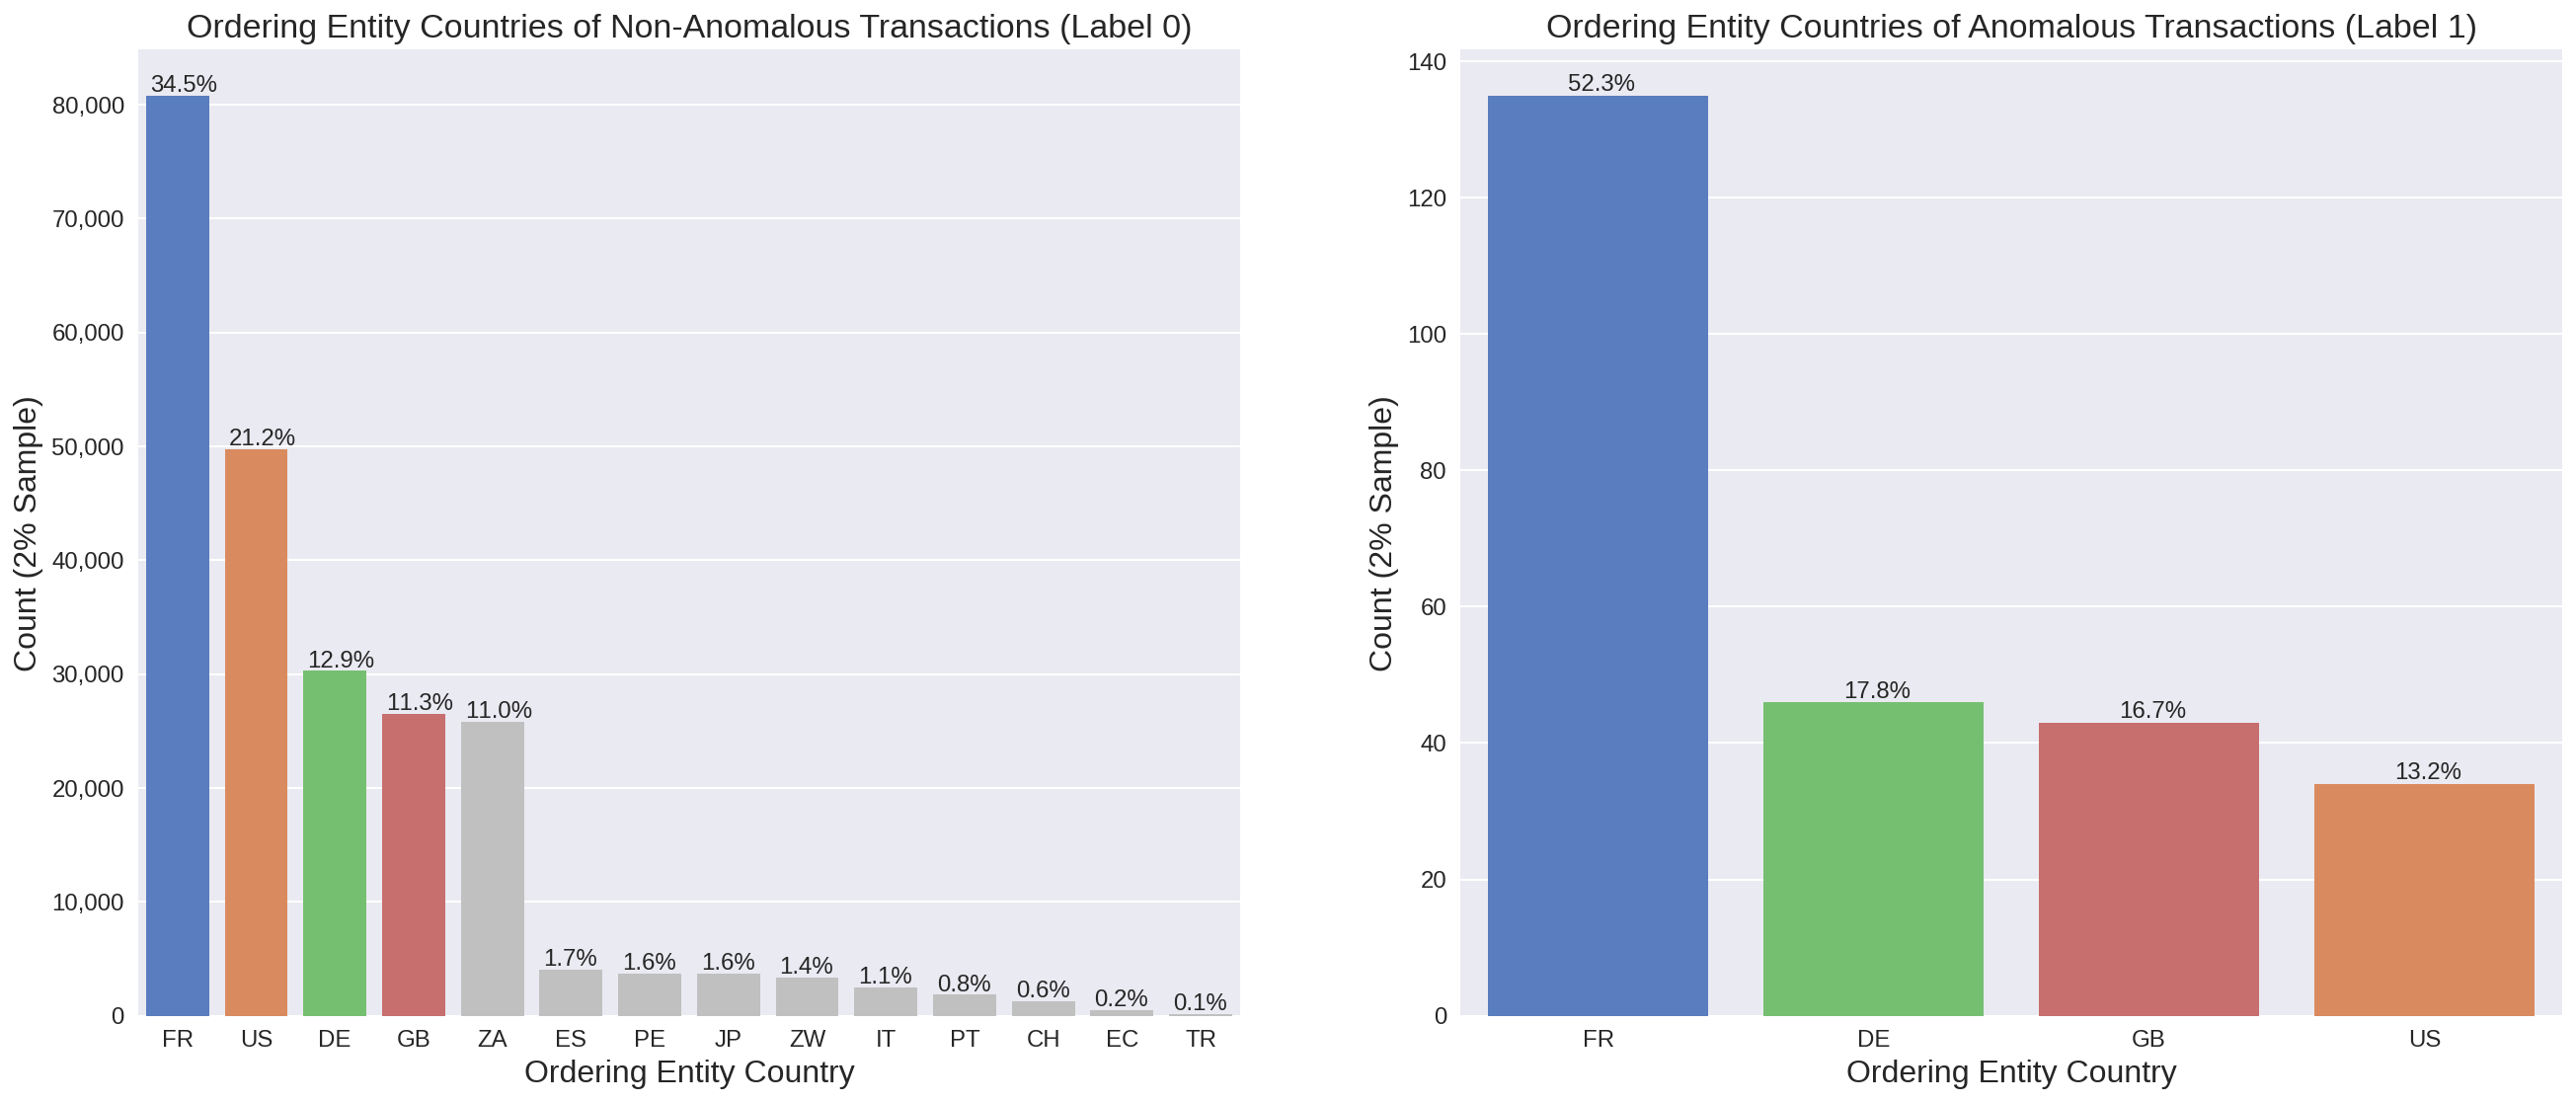

In [34]:
# Define figure and axes
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(22, 9))

# Set consistent color palette where y-axis values in both axes, otherwise silver
palette = sns.color_palette('muted', as_cmap=True)*2
palette_map = {}
for val, color in zip(viz_df['OrderingCountry'].value_counts().index, palette):
    if val in viz_df[viz_df.Label == 0]['OrderingCountry'].value_counts().index \
    and val in viz_df[viz_df.Label == 1]['OrderingCountry'].value_counts().index:
        palette_map[val] = color
    else:
        palette_map[val]= 'silver'

# Plot countplot of non-anomalous transactions
sns.countplot(x='OrderingCountry', data=viz_df[viz_df.Label == 0], ax=ax1, 
              order=viz_df[viz_df.Label == 0]['OrderingCountry'].value_counts().index,  # Order descending
              palette=palette_map)

# Plot countplot of anomalous transactions
sns.countplot(x='OrderingCountry', data=viz_df[viz_df.Label == 1], ax=ax2, 
              order=viz_df[viz_df.Label == 1]['OrderingCountry'].value_counts().index,  # Order descending
              palette=palette_map)

# Print percentages on top of bars (ax1)
for p in ax1.patches:
    txt = str(round(p.get_height() / viz_df[viz_df.Label == 0].shape[0]*100, 1)) + '%'
    txt_x = p.get_x()+0.05
    txt_y = p.get_height()+350
    ax1.text(txt_x, txt_y, txt, fontsize=12)

# Print percentages on top of bars (ax2)
for p in ax2.patches:
    txt = str(round(p.get_height() / viz_df[viz_df.Label == 1].shape[0]*100, 1)) + '%'
    txt_x = p.get_x()+0.29
    txt_y = p.get_height()+0.7
    ax2.text(txt_x, txt_y, txt, fontsize=12)

ax1.set_title('Ordering Entity Countries of Non-Anomalous Transactions (Label 0)', fontsize=17)
ax1.set_xlabel('Ordering Entity Country', fontsize=16)
ax1.set_xticklabels(ax1.get_xticklabels(), fontsize=12)
ax1.set_ylabel('Count (2% Sample)', fontsize=16)
ax1.set_yticklabels(['{:,}'.format(int(x)) for x in ax1.get_yticks()], fontsize=12)
ax2.set_title('Ordering Entity Countries of Anomalous Transactions (Label 1)', fontsize=17)
ax2.set_xlabel('Ordering Entity Country', fontsize=16)
ax2.set_xticklabels(ax2.get_xticklabels(), fontsize=12)
ax2.set_ylabel('Count (2% Sample)', fontsize=16)
ax2.set_yticklabels(ax2.get_yticks().astype(int), fontsize=12);

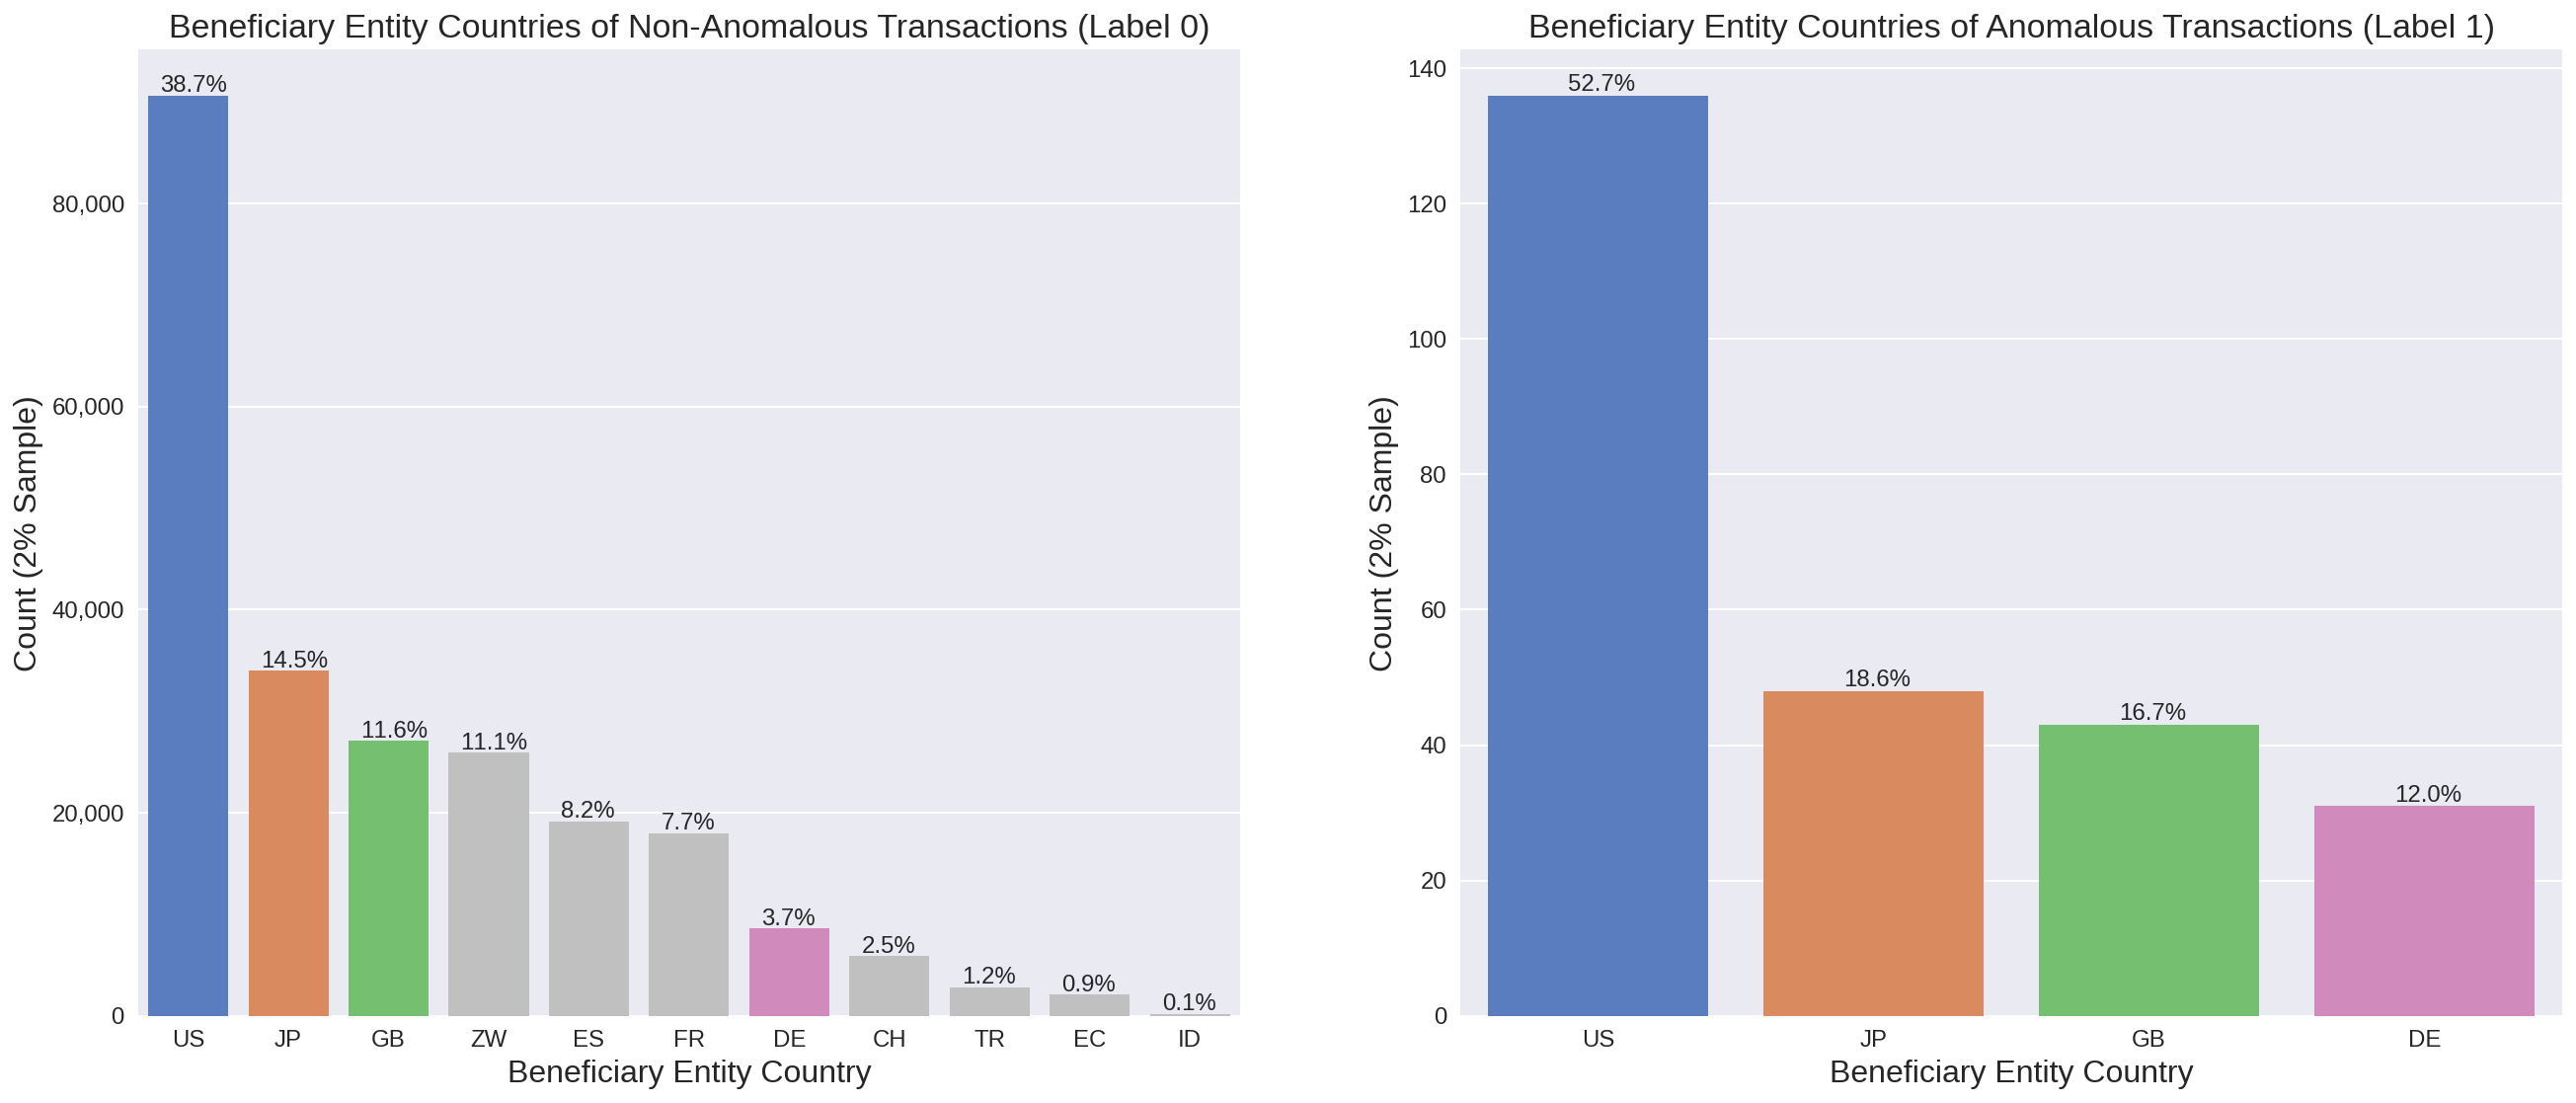

In [37]:
# Define figure and axes
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(22, 9))

# Set consistent color palette where y-axis values in both axes, otherwise silver
palette = sns.color_palette('muted', as_cmap=True)*2
palette_map = {}
for val, color in zip(viz_df['BeneficiaryCountry'].value_counts().index, palette):
    if val in viz_df[viz_df.Label == 0]['BeneficiaryCountry'].value_counts().index \
    and val in viz_df[viz_df.Label == 1]['BeneficiaryCountry'].value_counts().index:
        palette_map[val] = color
    else:
        palette_map[val]= 'silver'

# Plot countplot of non-anomalous transactions
sns.countplot(x='BeneficiaryCountry', data=viz_df[viz_df.Label == 0], ax=ax1, 
              order=viz_df[viz_df.Label == 0]['BeneficiaryCountry'].value_counts().index,  # Order descending
              palette=palette_map)

# Plot countplot of anomalous transactions
sns.countplot(x='BeneficiaryCountry', data=viz_df[viz_df.Label == 1], ax=ax2, 
              order=viz_df[viz_df.Label == 1]['BeneficiaryCountry'].value_counts().index,  # Order descending
              palette=palette_map)

# Print percentages on top of bars (ax1)
for p in ax1.patches:
    txt = str(round(p.get_height() / viz_df[viz_df.Label == 0].shape[0]*100, 1)) + '%'
    txt_x = p.get_x()+0.12
    txt_y = p.get_height()+350
    ax1.text(txt_x, txt_y, txt, fontsize=12)

# Print percentages on top of bars (ax2)
for p in ax2.patches:
    txt = str(round(p.get_height() / viz_df[viz_df.Label == 1].shape[0]*100, 1)) + '%'
    txt_x = p.get_x()+0.29
    txt_y = p.get_height()+0.7
    ax2.text(txt_x, txt_y, txt, fontsize=12)

ax1.set_title('Beneficiary Entity Countries of Non-Anomalous Transactions (Label 0)', fontsize=17)
ax1.set_xlabel('Beneficiary Entity Country', fontsize=16)
ax1.set_xticklabels(ax1.get_xticklabels(), fontsize=12)
ax1.set_ylabel('Count (2% Sample)', fontsize=16)
ax1.set_yticklabels(['{:,}'.format(int(x)) for x in ax1.get_yticks()], fontsize=12)
ax2.set_title('Beneficiary Entity Countries of Anomalous Transactions (Label 1)', fontsize=17)
ax2.set_xlabel('Beneficiary Entity Country', fontsize=16)
ax2.set_xticklabels(ax2.get_xticklabels(), fontsize=12)
ax2.set_ylabel('Count (2% Sample)', fontsize=16)
ax2.set_yticklabels(ax2.get_yticks().astype(int), fontsize=12);

**Remarks**:
- These visualizations bear resemblance to the sender banks visualization, where we have a large selection of values (countries in this case) among non-anomalous transactions and a much smaller subset of values among anomalous transactions. It does look like there is signal in this feature, given the marked difference between non-anomalous and anomalous transactions for both ordering and beneficiary entity countries.

<br>

## Create `InstructedAmountUSD` feature

Here we are going to create a new column with standardized instructed transaction amounts, as it wouldn't make much sense to leave the amounts in completely different scales. We'll scale all amounts to their USD conversion rates on 2022/01/12, the median transaction date in `train_df`.

Exchange rates were obtained from <a href='https://www.xe.com/currencytables/' >xe.com</a>.

In [38]:
# Exchange rate values on 2022/01/12 (median date of transactions in dataframe)
'1 NZD = 0.6845945591 USD'
'1 GBP = 1.3696247772 USD'
'1 CAD = 0.7999730579 USD'
'1 EUR = 1.1431474656 USD'
'1 AUD = 0.7277363105 USD'
'1 JPY = 0.0087157154 USD'
'1 INR = 0.0135530538 USD'

conversion_rates = {'NZD': 0.6845945591, 'GBP': 1.3696247772, 'CAD': 0.7999730579, 'EUR': 1.1431474656, \
                    'AUD': 0.7277363105, 'JPY': 0.0087157154, 'INR': 0.0135530538, 'USD': 1.0}

# Create new column in train and test dataframes with conversion_rates dictionary
mapping_expr = F.create_map([F.lit(x) for x in chain(*conversion_rates.items())])

train_df = train_df.withColumn('InstructedAmountUSD', \
                               mapping_expr[F.col('InstructedCurrency')]*F.col('InstructedAmount'))
test_df = test_df.withColumn('InstructedAmountUSD', \
                             mapping_expr[F.col('InstructedCurrency')]*F.col('InstructedAmount'))

In [ ]:
# Display sample of transactions to verify accuracy of InstructedAmountUSD column
train_df.select('InstructedCurrency', 'InstructedAmount', 'InstructedAmountUSD').show(10, truncate=False)

### Visualize target class distributions of instructed transaction amounts in USD

We'll only plot instructed transaction amounts, since settlement amounts are essentially equivalent to instructed amounts less deductions for fees and transfer/forex charges. We'll also only plot the `InstructedAmountUSD` column values, i.e. instructed amounts that have been standardized to the USD exchange rate, as it wouldn't be very informative to plot the wildly varying scales of the different currencies together.

In [43]:
# Sample 5% of train_df for visualizations (approximately 235k observations) for efficiency
viz_cols = ['InstructedAmountUSD', 'Label']
viz_df = train_df.select(viz_cols).sample(withReplacement=False, fraction=0.05, seed=42).toPandas()

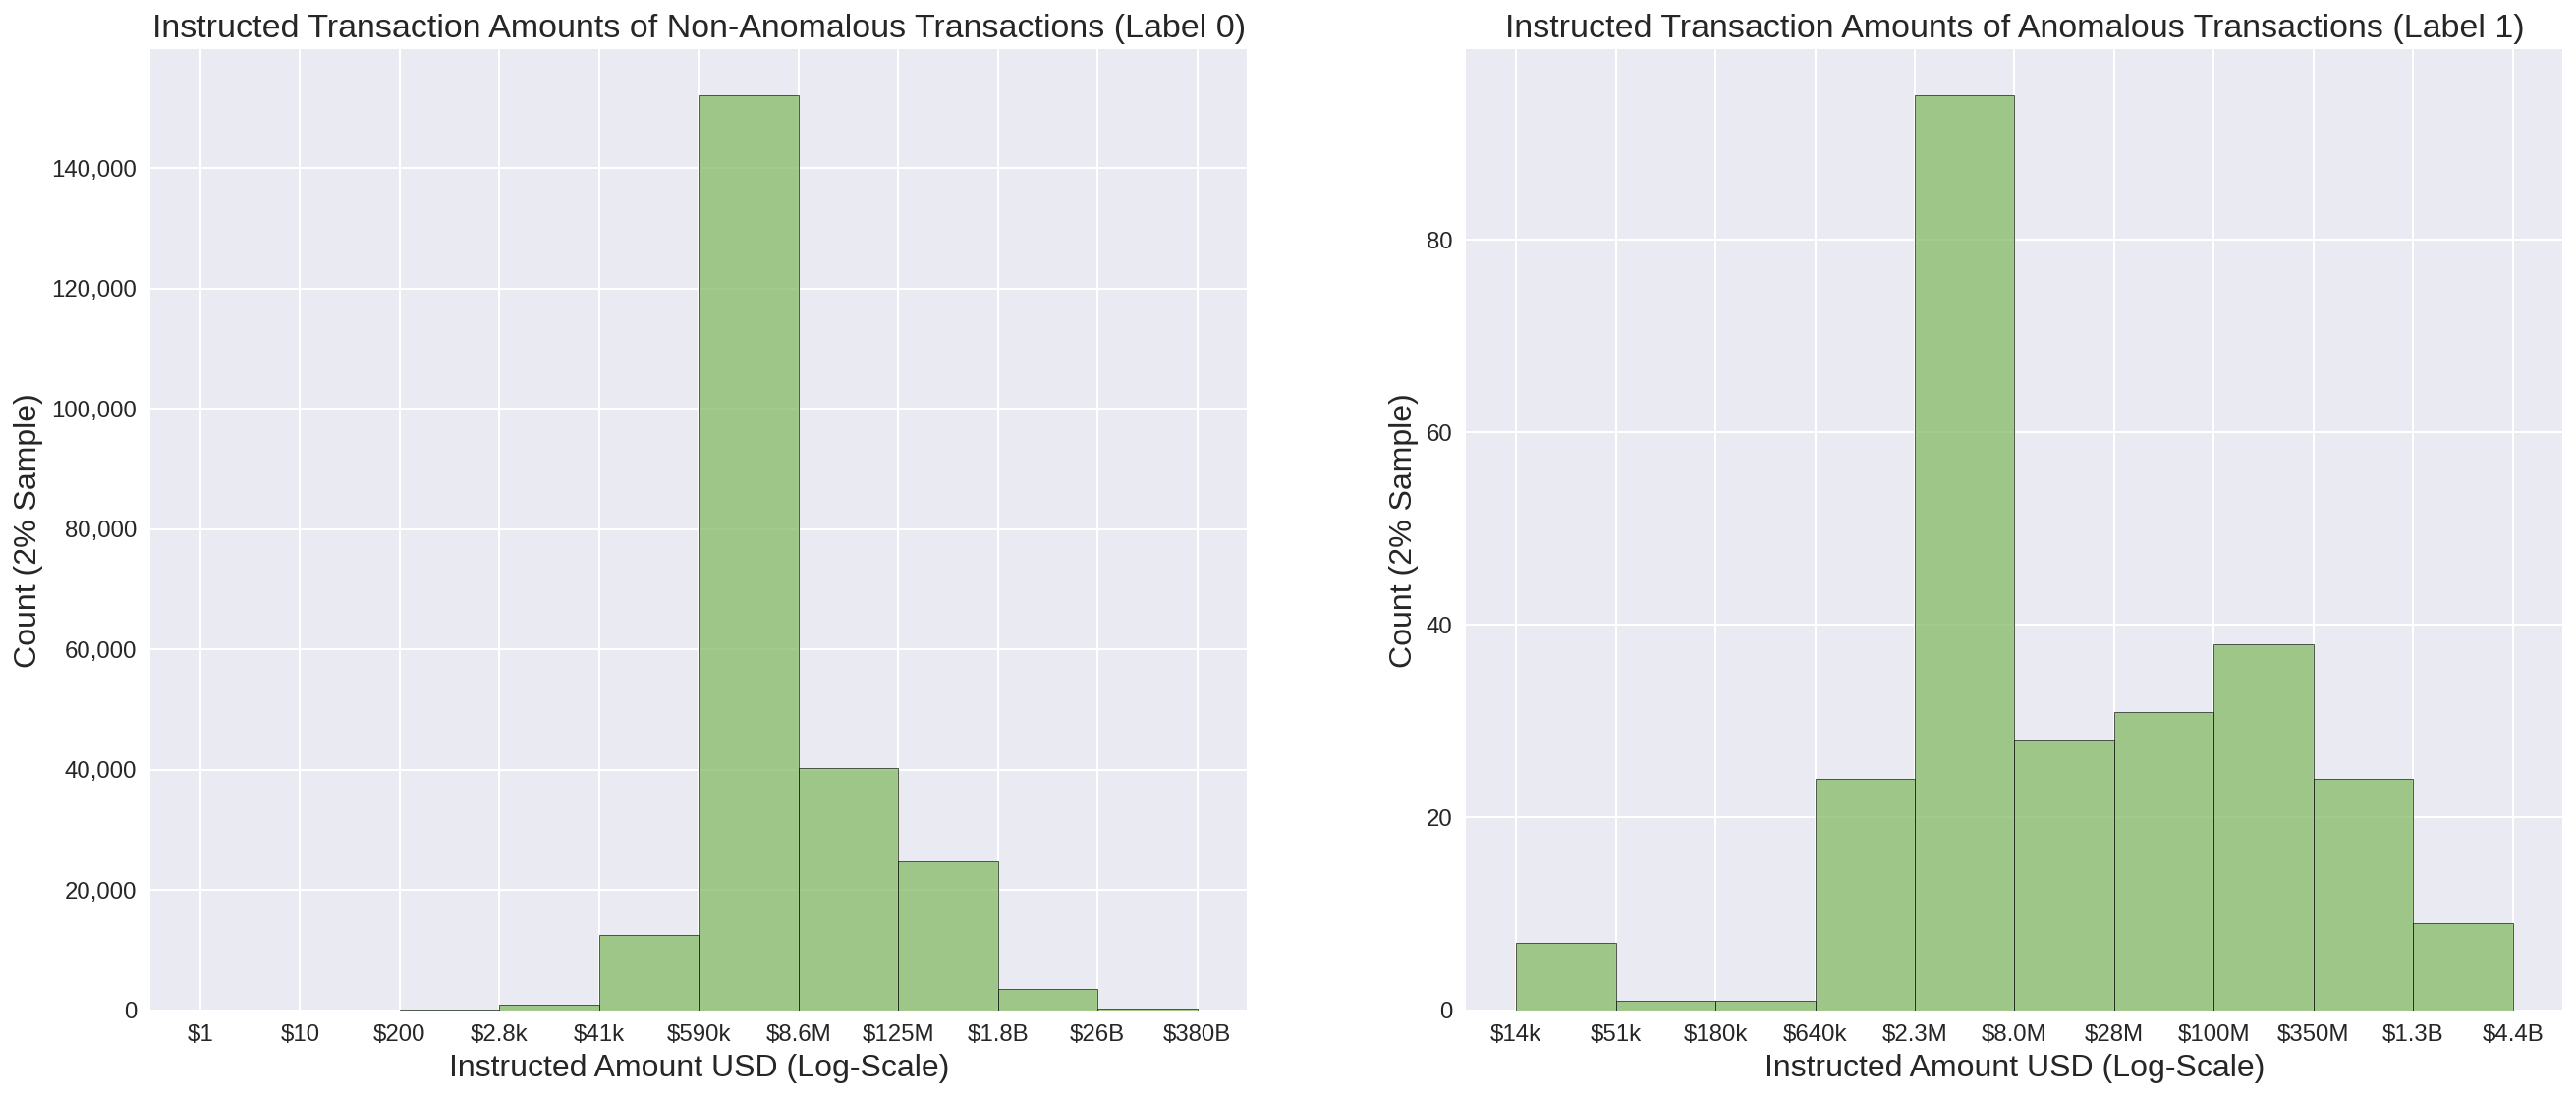

In [48]:
# Define figure and axes
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(22, 9))

# Plot histogram of non-anomalous transactions; log x-axis due to extreme right-skew
sns.histplot(x='InstructedAmountUSD', data=viz_df[viz_df.Label == 0], ax=ax1, bins=10, log_scale=True, color='#85bb65')

# Plot histogram of anomalous transactions; log x-axis due to extreme right-skew
sns.histplot(x='InstructedAmountUSD', data=viz_df[viz_df.Label == 1], ax=ax2, bins=10, log_scale=True, color='#85bb65')

ax1.set_title('Instructed Transaction Amounts of Non-Anomalous Transactions (Label 0)', fontsize=17)
ax1.set_xlabel('Instructed Amount USD (Log-Scale)', fontsize=16)
ax1.set_ylabel('Count (2% Sample)', fontsize=16)
ax2.set_title('Instructed Transaction Amounts of Anomalous Transactions (Label 1)', fontsize=17)
ax2.set_xlabel('Instructed Amount USD (Log-Scale)', fontsize=16)
ax2.set_ylabel('Count (2% Sample)', fontsize=16);

# Set xticks to match bin widths
ax1.set_xticks([bin.get_x() for bin in ax1.patches] + [viz_df[viz_df.Label == 0]['InstructedAmountUSD'].max()])
ax2.set_xticks([bin.get_x() for bin in ax2.patches] + [viz_df[viz_df.Label == 1]['InstructedAmountUSD'].max()]);
# Change xtick labels to more readable format
ax1.set_xticklabels(['$1', '$10', '$200', '$2.8k', '$41k', '$590k', '$8.6M', '$125M', '$1.8B', '$26B', '$380B'], fontsize=12)
ax1.set_yticklabels(['{:,}'.format(int(x)) for x in ax1.get_yticks()], fontsize=12)
ax2.set_xticklabels(['$14k', '$51k', '$180k', '$640k', '$2.3M', '$8.0M', '$28M', '$100M', '$350M', '$1.3B', '$4.4B'], fontsize=12)
ax2.set_yticklabels(ax2.get_yticks().astype(int), fontsize=12);

**Remarks:**
- The distributions of instructed transaction amounts for both non-anomalous and anomalous transactions are both extremely right-skewed, which we can tell because the distributions look more or less normal after log-scaling.
- Non-anomalous transactions appear to have a much larger range of values, ranging from \$1 all the way to over \$380B. The range for anomalous transactions is much more narrow, ranging from \$30k to just under $4.5B.

<br>

## Create `IntermediaryTransactions` feature by counting number of duplicate UETR occurrences for each unique UETR code

This feature will tell us the number of intermediary transactions conducted in each end-to-end transaction. This can be calculated for each end-to-end transaction by counting how many times the UETR for that end-to-end transaction code appears.

In [ ]:
# Create temporary table to use for SQL query
train_df.createOrReplaceTempView('train_df_sql')

# Create new feature using SQL
join_sql = """
WITH UETRCounts AS (
SELECT UETR, 
COUNT(UETR)-1 AS IntermediaryTransactions
FROM train_df_sql
GROUP BY UETR
)
SELECT train_df_sql.*, 
UETRCounts.IntermediaryTransactions
FROM train_df_sql
LEFT JOIN UETRCounts
    ON train_df_sql.UETR = UETRCounts.UETR
"""

train_df = spark.sql(join_sql)

### Accuracy check

In [ ]:
# Retrieve random UETR codes of transactions where entity used 0, 1 and 2 intermediary banks
sample1_UETR = train_df.filter(train_df.IntermediaryTransactions == 0).sample(False, 0.00001).limit(1).collect()[0]['UETR']
sample2_UETR = train_df.filter(train_df.IntermediaryTransactions == 1).sample(False, 0.00001).limit(1).collect()[0]['UETR']
sample3_UETR = train_df.filter(train_df.IntermediaryTransactions == 2).sample(False, 0.0001).limit(1).collect()[0]['UETR']

# Display sample of transactions to verify accuracy of OriginalSender and FinalReceiver
#  columns; IntermediaryTransactions value should match number of rows in sample
cols_to_show = ['MessageId', 'UETR', 'Sender', 'Receiver', 'IntermediaryTransactions']
train_df.filter(train_df.UETR == sample1_UETR).select(cols_to_show).show(truncate=False)
train_df.filter(train_df.UETR == sample2_UETR).select(cols_to_show).show(truncate=False)
train_df.filter(train_df.UETR == sample3_UETR).select(cols_to_show).show(truncate=False)

### Repeat for `test_df`

In [ ]:
# Create temporary table to use for SQL query
test_df.createOrReplaceTempView('test_df_sql')

# Create new features using SQL
join_sql = """
WITH UETRCounts AS (
SELECT UETR, 
COUNT(UETR)-1 AS IntermediaryTransactions
FROM test_df_sql
GROUP BY UETR
)
SELECT test_df_sql.*, 
UETRCounts.IntermediaryTransactions
FROM test_df_sql
LEFT JOIN UETRCounts
    ON test_df_sql.UETR = UETRCounts.UETR
"""

test_df = spark.sql(join_sql)

<br>

## Create `OriginalSender` and `FinalReceiver` features by identifying original `Sender` and final `Receiver` for each end-to-end transaction

As described in the preliminary EDA section, the correct way to associate ordering and beneficiary accounts with their proper banks is to identify the `Sender` bank in the first transaction of the end-to-end transaction and the `Receiver` bank in the last transaction of the end-to-end transaction. Below, we'll create new columns which do just that.

In [58]:
# Create temporary table to use for SQL query
train_df.createOrReplaceTempView('train_df_sql')

# Create new features using SQL
join_sql = """
WITH EarliestTransaction AS (
SELECT UETR, 
Sender, 
Timestamp
FROM train_df_sql 
WHERE (UETR, Timestamp) IN
    (SELECT UETR, MIN(Timestamp) 
    FROM train_df_sql 
    GROUP BY UETR)
), 
LatestTransaction AS (
SELECT UETR, 
Receiver, 
Timestamp
FROM train_df_sql 
WHERE (UETR, Timestamp) IN
    (SELECT UETR, MAX(Timestamp) 
    FROM train_df_sql 
    GROUP BY UETR)
)
SELECT train_df_sql.*, 
EarliestTransaction.Sender AS OriginalSender, 
LatestTransaction.Receiver AS FinalReceiver
FROM train_df_sql
LEFT JOIN EarliestTransaction
    ON train_df_sql.UETR = EarliestTransaction.UETR
LEFT JOIN LatestTransaction
    ON train_df_sql.UETR = LatestTransaction.UETR
"""

train_df = spark.sql(join_sql)

### Accuracy check

In [ ]:
# Retrieve three random UETR codes of transactions where entity used intermediary banks
sample = train_df.filter(train_df.IntermediaryTransactions > 0).sample(False, 0.0001).limit(3).collect()
UETRs = [sample[row]['UETR'] for row in range(3)]

# Display sample of transactions to verify accuracy of OriginalSender and FinalReceiver columns
cols_to_show = ['Timestamp', 'UETR', 'Sender', 'Receiver', 'OriginalSender', 'FinalReceiver']
train_df.filter(train_df.UETR == UETRs[0]).select(cols_to_show).show(truncate=False)
train_df.filter(train_df.UETR == UETRs[1]).select(cols_to_show).show(truncate=False)
train_df.filter(train_df.UETR == UETRs[2]).select(cols_to_show).show(truncate=False)

### Repeat for `test_df`

In [ ]:
# Create temporary table to use for SQL query
test_df.createOrReplaceTempView('test_df_sql')

# Create new features using SQL
join_sql = """
WITH EarliestTransaction AS (
SELECT UETR, 
Sender, 
Timestamp
FROM test_df_sql 
WHERE (UETR, Timestamp) IN
    (SELECT UETR, MIN(Timestamp) 
    FROM test_df_sql 
    GROUP BY UETR)
), 
LatestTransaction AS (
SELECT UETR, 
Receiver, 
Timestamp
FROM test_df_sql 
WHERE (UETR, Timestamp) IN
    (SELECT UETR, MAX(Timestamp) 
    FROM test_df_sql 
    GROUP BY UETR)
)
SELECT test_df_sql.*, 
EarliestTransaction.Sender AS OriginalSender, 
LatestTransaction.Receiver AS FinalReceiver
FROM test_df_sql
LEFT JOIN EarliestTransaction
    ON test_df_sql.UETR = EarliestTransaction.UETR
LEFT JOIN LatestTransaction
    ON test_df_sql.UETR = LatestTransaction.UETR
"""

test_df = spark.sql(join_sql)

### Visualize target class distributions of senders, final senders, receivers, and final receivers

Here we will do a similar visualization as we did in the EDA section, except instead of comparing the same banks across non-anomalous and anomalous transactions, the primary comparison here will be the difference in frequency between how often a given bank is a regular sender vs. original sender, and regular receiver vs. final receiver.

If these visualizations show a great deal of difference between the two across multiple banks, it'll tell us that these features carry a lot of signal and are worth bringing into the final dataframe as one hot encoded features.

In [76]:
# Sample 5% of train_df for visualizations (approximately 235k observations) for efficiency
viz_cols = ['Sender', 'OriginalSender', 'Label']
viz_df = train_df.select(viz_cols).sample(withReplacement=False, fraction=0.05, seed=42).toPandas()
# Melt dataframe so original/final senders and receivers and can be plotted side-by-side
viz_df = pd.melt(viz_df, id_vars=['Label'], value_vars=['Sender', 'OriginalSender'], var_name='Type', value_name='Bank')

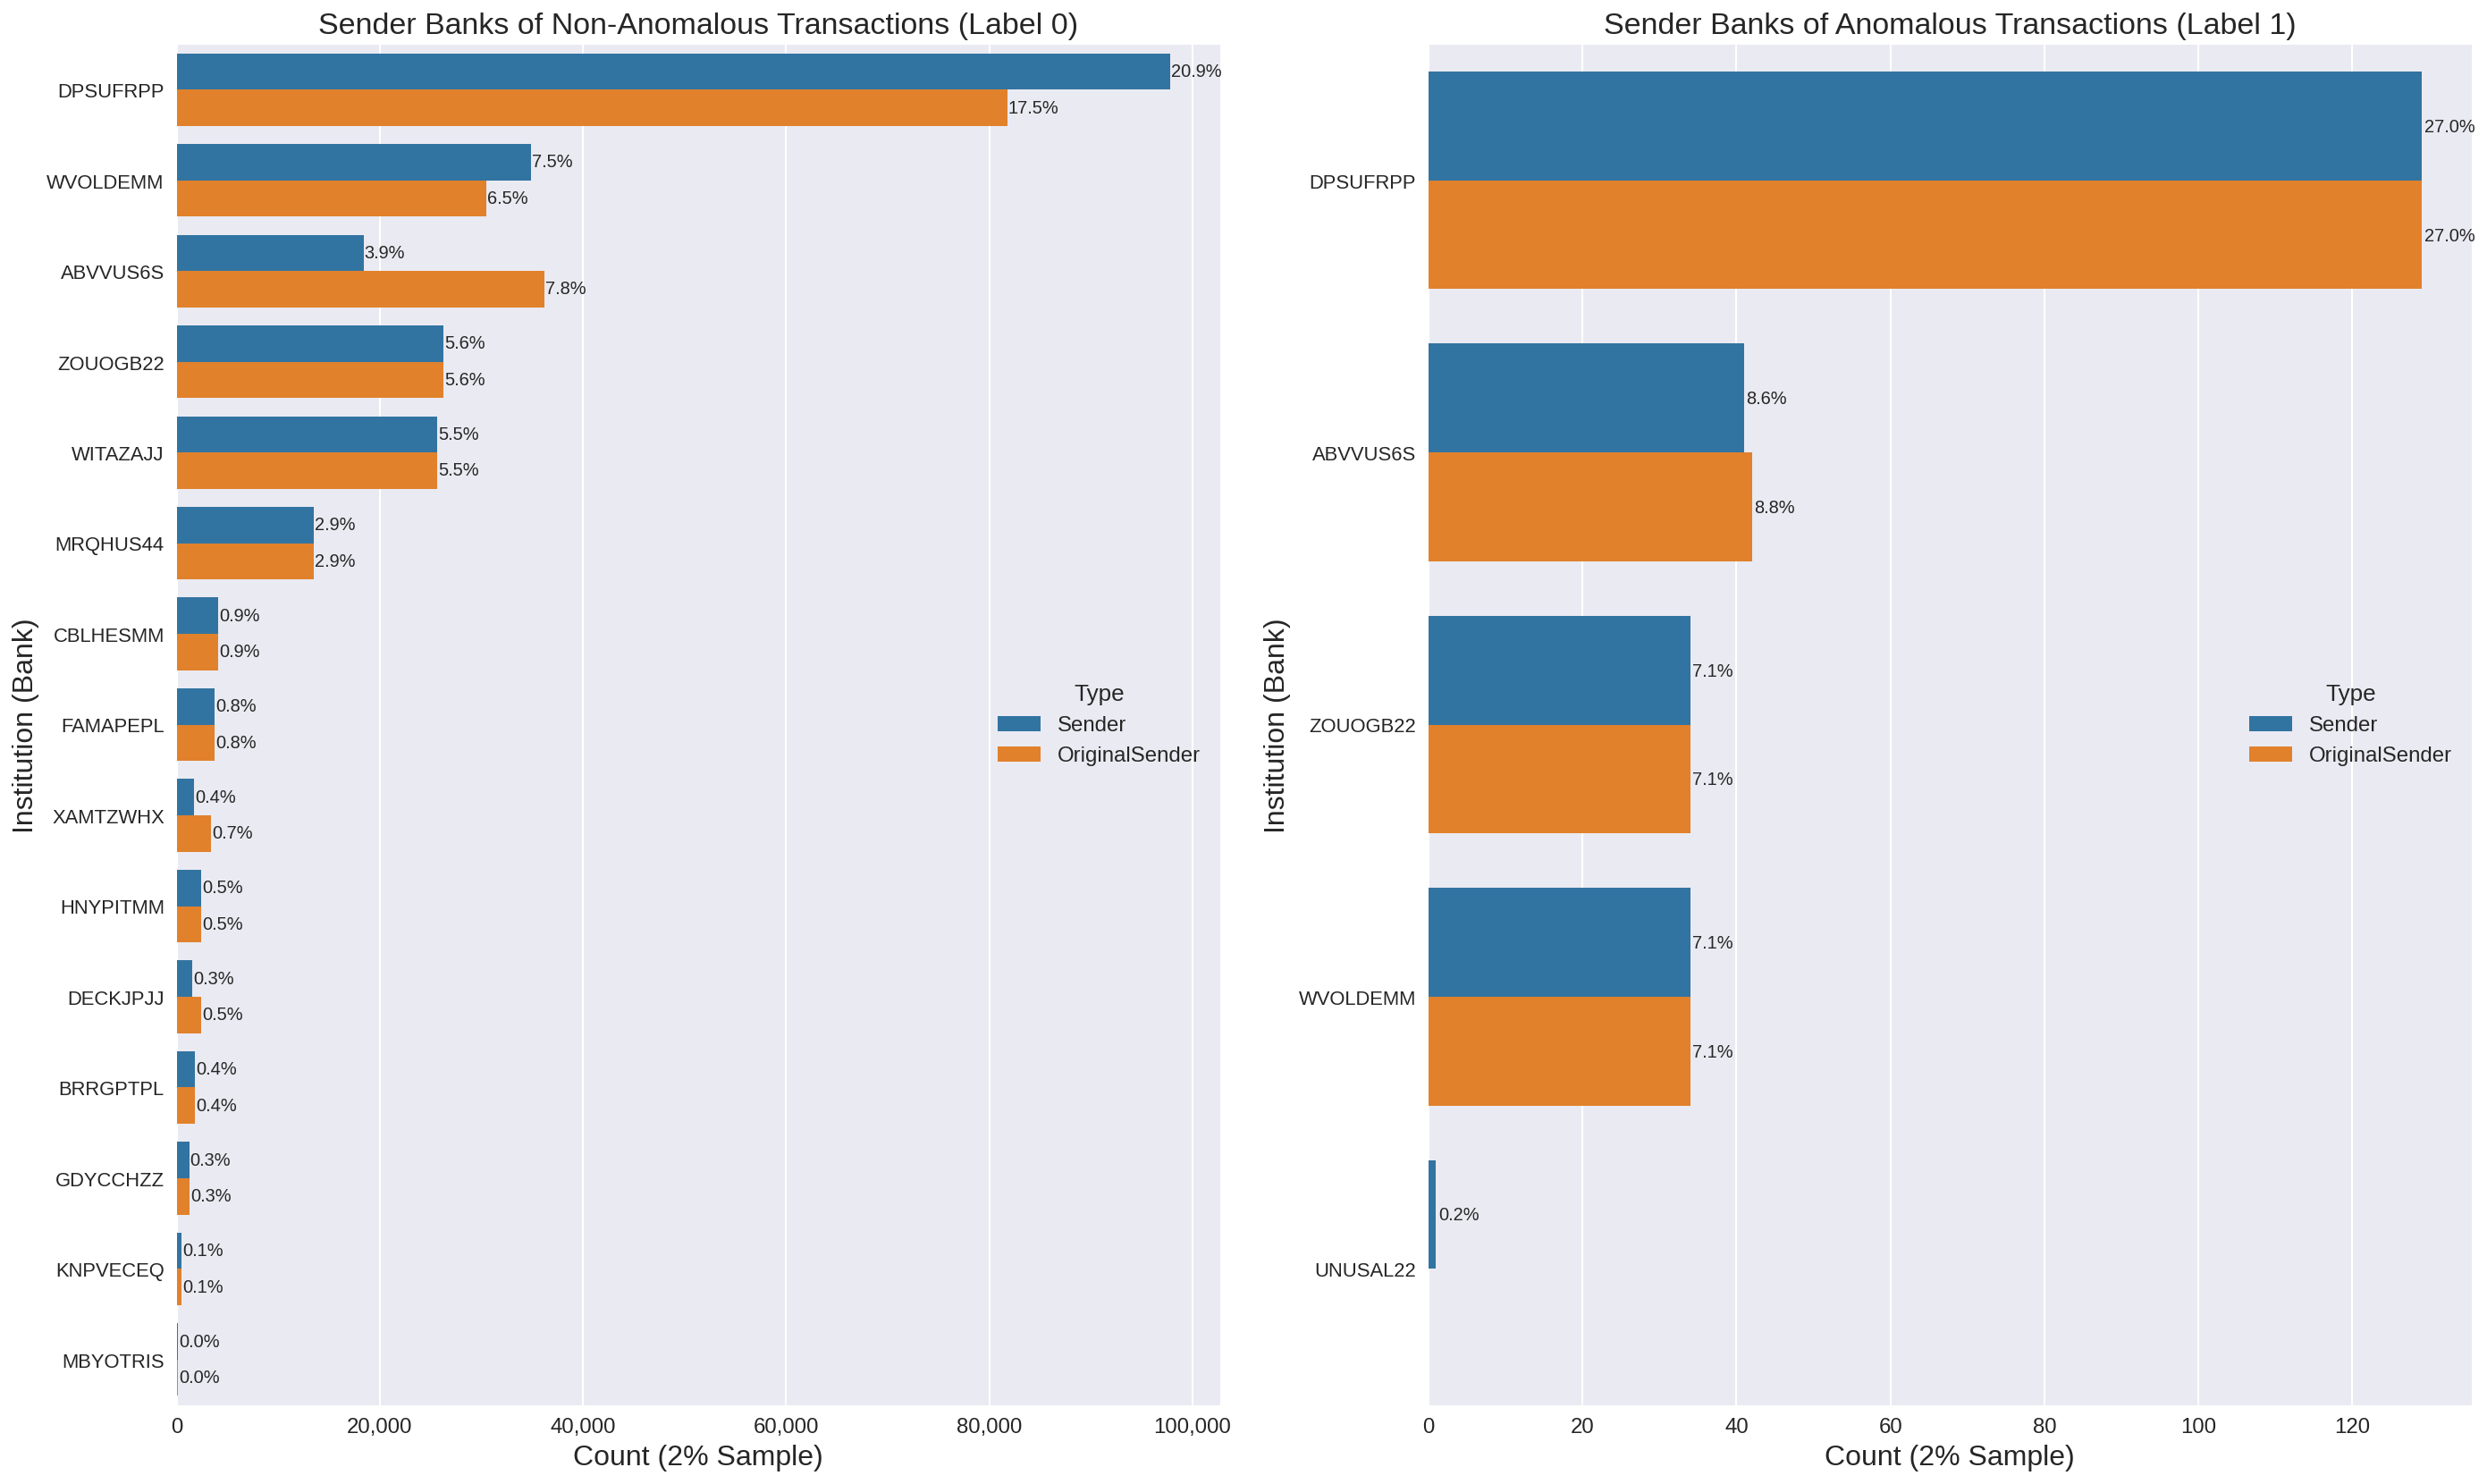

In [77]:
# Define figure and axes
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(23, 14))

# Plot countplot of non-anomalous transactions
sns.countplot(y='Bank', data=viz_df[viz_df.Label == 0], ax=ax1, hue='Type', 
              order=viz_df[viz_df.Label == 0]['Bank'].value_counts().index,  # Order descending
              palette='tab10')

# Plot countplot of anomalous transactions
sns.countplot(y='Bank', data=viz_df[viz_df.Label == 1], ax=ax2, hue='Type', 
              order=viz_df[viz_df.Label == 1]['Bank'].value_counts().index,  # Order descending
              palette='tab10')

# # Print percentages to the right of bars (ax1)
for p in ax1.patches:
    percentage = '{:.1f}%'.format(100 * p.get_width()/viz_df[viz_df.Label == 0].shape[0])
    x = p.get_x() + p.get_width()+100
    y = p.get_y() + p.get_height()-0.15
    ax1.annotate(percentage, (x, y))

# # Print percentages to the right of bars (ax2)
for p in ax2.patches:
    percentage = '{:.1f}%'.format(100 * p.get_width()/viz_df[viz_df.Label == 1].shape[0])
    x = p.get_x() + p.get_width()+0.3
    y = p.get_y() + p.get_height()-0.18
    ax2.annotate(percentage, (x, y))

ax1.set_title('Sender Banks of Non-Anomalous Transactions (Label 0)', fontsize=17)
ax1.set_xlabel('Count (2% Sample)', fontsize=16)
ax1.set_xticklabels(['{:,}'.format(int(x)) for x in ax1.get_xticks()], fontsize=12)
ax1.set_ylabel('Institution (Bank)', fontsize=16)
ax1.set_yticklabels(ax1.get_yticklabels(), fontsize=11)
ax1.legend(title='Type', loc='center right', fontsize=12, title_fontsize=13)
ax2.set_title('Sender Banks of Anomalous Transactions (Label 1)', fontsize=17)
ax2.set_xlabel('Count (2% Sample)', fontsize=16)
ax2.set_xticklabels(ax2.get_xticks().astype(int), fontsize=12)
ax2.set_ylabel('Institution (Bank)', fontsize=16)
ax2.set_yticklabels(ax2.get_yticklabels(), fontsize=11)
ax2.legend(title='Type', loc='center right', fontsize=12, title_fontsize=13);

In [78]:
# Sample 5% of train_df for visualizations (approximately 235k observations) for efficiency
viz_cols = ['Receiver', 'FinalReceiver', 'Label']
viz_df = train_df.select(viz_cols).sample(withReplacement=False, fraction=0.05, seed=42).toPandas()
viz_df = pd.melt(viz_df, id_vars=['Label'], value_vars=['Receiver', 'FinalReceiver'], var_name='Type', value_name='Bank')

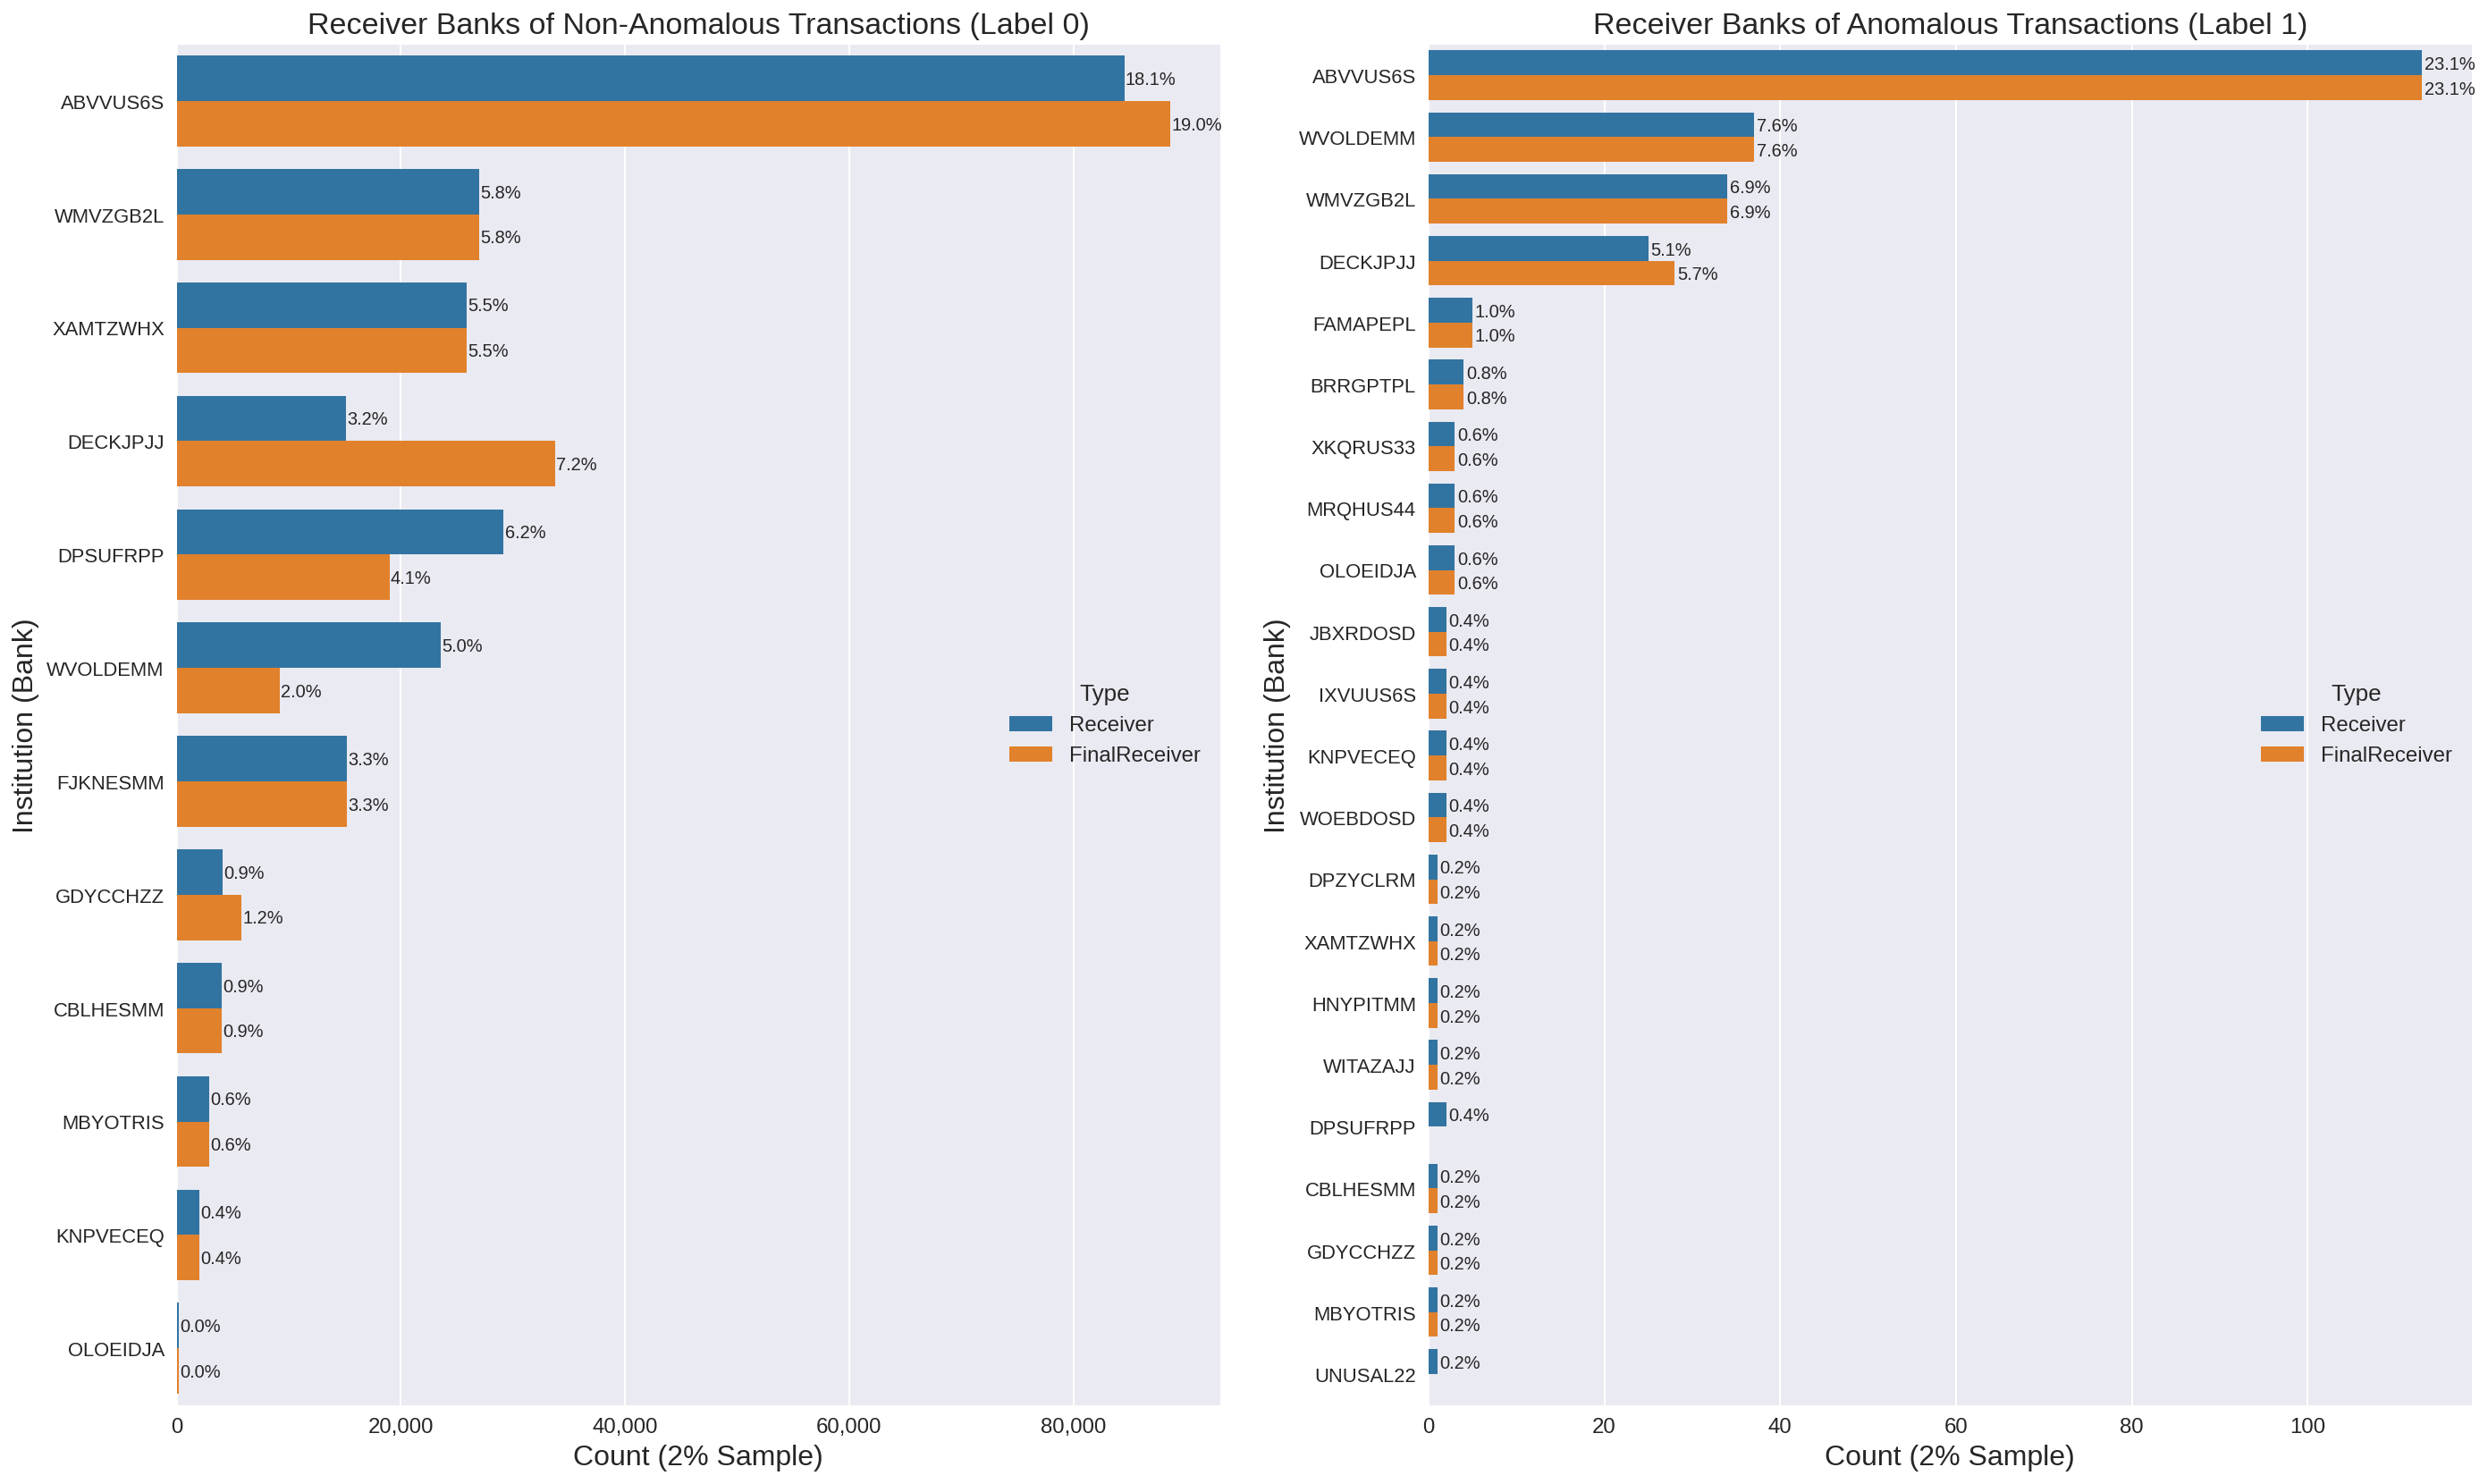

In [82]:
# Define figure and axes
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(23, 14))

# Plot countplot of non-anomalous transactions
sns.countplot(y='Bank', data=viz_df[viz_df.Label == 0], ax=ax1, hue='Type', 
              order=viz_df[viz_df.Label == 0]['Bank'].value_counts().index,  # Order descending
              palette='tab10')

# Plot countplot of anomalous transactions
sns.countplot(y='Bank', data=viz_df[viz_df.Label == 1], ax=ax2, hue='Type', 
              order=viz_df[viz_df.Label == 1]['Bank'].value_counts().index,  # Order descending
              palette='tab10')

# # Print percentages to the right of bars (ax1)
for p in ax1.patches:
    percentage = '{:.1f}%'.format(100 * p.get_width()/viz_df[viz_df.Label == 0].shape[0])
    x = p.get_x() + p.get_width()+100
    y = p.get_y() + p.get_height()-0.15
    ax1.annotate(percentage, (x, y))

# # Print percentages to the right of bars (ax2)
for p in ax2.patches:
    percentage = '{:.1f}%'.format(100 * p.get_width()/viz_df[viz_df.Label == 1].shape[0])
    x = p.get_x() + p.get_width()+0.3
    y = p.get_y() + p.get_height()-0.1
    ax2.annotate(percentage, (x, y))

ax1.set_title('Receiver Banks of Non-Anomalous Transactions (Label 0)', fontsize=17)
ax1.set_xlabel('Count (2% Sample)', fontsize=16)
ax1.set_xticklabels(['{:,}'.format(int(x)) for x in ax1.get_xticks()], fontsize=12)
ax1.set_ylabel('Institution (Bank)', fontsize=16)
ax1.set_yticklabels(ax1.get_yticklabels(), fontsize=11)
ax1.legend(title='Type', loc='center right', fontsize=12, title_fontsize=13)
ax2.set_title('Receiver Banks of Anomalous Transactions (Label 1)', fontsize=17)
ax2.set_xlabel('Count (2% Sample)', fontsize=16)
ax2.set_xticklabels(ax2.get_xticks().astype(int), fontsize=12)
ax2.set_ylabel('Institution (Bank)', fontsize=16)
ax2.set_yticklabels(ax2.get_yticklabels(), fontsize=11)
ax2.legend(title='Type', loc='center right', fontsize=12, title_fontsize=13);

**Remarks**
- While there is definitely a noticeable difference in frequency between original vs. final sender/receiver for some banks, overall the difference is minor or non-existent for the majority. Given the vast size of our dataframe as is, these features don't appear worth keeping as one hot encoded variables.

<br>

## Create `Flagged` feature by joining `Flags` column of `banks_df`

As we saw in the preliminary EDA section, none of the accounts with non-zero flags are associated with `OrderingAccount`s; they are all associated with `BeneficiaryAccount`s. It therefore wouldn't make any sense to create a column of `OrderingAccontFlag`s as every value in it would be `0`. We'll only make a column of `BeneficiaryAccountFlag`s.

In [ ]:
# Create temporary tables to use for SQL query
train_df.createOrReplaceTempView('train_df_sql')
banks_df.createOrReplaceTempView('banks_df_sql')

# Create new feature using SQL
join_sql = """
SELECT train_df_sql.*, 
banks_df_sql.Account AS MatchingBeneficiaryAccount, 
banks_df_sql.Flags AS BeneficiaryAccountFlag
FROM train_df_sql
LEFT JOIN banks_df_sql
    ON train_df_sql.BeneficiaryAccount = banks_df_sql.Account
"""

train_df = spark.sql(join_sql)

### Accuracy check

In [ ]:
# Retrieve three random UETR codes of transactions with non-zero flags
sample = train_df.filter(train_df.BeneficiaryAccountFlag != 0).sample(False, 0.1).limit(3).collect()
UETRs = [sample[row]['UETR'] for row in range(3)]

# Only show relevant columns of train_df
cols_to_show_train = ['Timestamp', 'UETR', 'OrderingAccount', 'BeneficiaryAccount', \
                      'MatchingBeneficiaryAccount', 'BeneficiaryAccountFlag']

# Only show relevant columns of banks_df
cols_to_show_bank = ['Account', 'Flags']

# Get selected beneficiary accounts of train_df to display side-by-side with matching account in banks_df
first_account = train_df.filter(train_df.UETR == UETRs[0]).collect()[0]['BeneficiaryAccount']
second_account = train_df.filter(train_df.UETR == UETRs[1]).collect()[0]['BeneficiaryAccount']
third_account = train_df.filter(train_df.UETR == UETRs[2]).collect()[0]['BeneficiaryAccount']

train_df.filter(train_df.UETR == UETRs[0]).select(cols_to_show_train).show(truncate=False, vertical=True)
banks_df.filter(banks_df.Account == first_account).select(cols_to_show_bank).show(truncate=False, vertical=True)
print('\n')
train_df.filter(train_df.UETR == UETRs[1]).select(cols_to_show_train).show(truncate=False, vertical=True)
banks_df.filter(banks_df.Account == second_account).select(cols_to_show_bank).show(truncate=False, vertical=True)
print('\n')
train_df.filter(train_df.UETR == UETRs[2]).select(cols_to_show_train).show(truncate=False, vertical=True)
banks_df.filter(banks_df.Account == third_account).select(cols_to_show_bank).show(truncate=False, vertical=True)

### Repeat for `test_df`

In [ ]:
# Create temporary table to use for SQL query
test_df.createOrReplaceTempView('test_df_sql')

# Create new feature using SQL
join_sql = """
SELECT test_df_sql.*, 
banks_df_sql.Account AS MatchingBeneficiaryAccount, 
banks_df_sql.Flags AS BeneficiaryAccountFlag
FROM test_df_sql
LEFT JOIN banks_df_sql
    ON test_df_sql.BeneficiaryAccount = banks_df_sql.Account
"""

test_df = spark.sql(join_sql)

In [ ]:
# Check for null values in new BeneficiaryAccountFlag column
train_df.where(F.col('BeneficiaryAccountFlag').isNull() | F.isnan('BeneficiaryAccountFlag')).count()

In [ ]:
# Replace null values in BeneficiaryAccountFlag with value of '2' which will signify that there is no 
# matching account in banks_df
train_df = train_df.fillna(value=2, subset='BeneficiaryAccountFlag')
test_df = test_df.fillna(value=2, subset='BeneficiaryAccountFlag')

assert train_df.where(F.col('BeneficiaryAccountFlag').isNull() | F.isnan('BeneficiaryAccountFlag')).count() == 0
assert test_df.where(F.col('BeneficiaryAccountFlag').isNull() | F.isnan('BeneficiaryAccountFlag')).count() == 0

In [ ]:
# Check distribution of flagged beneficiary accounts in train_df
train_df.groupBy('Label', 'BeneficiaryAccountFlag').agg({'Label': 'count'}).show()

**Remarks:**
- The math checks out on the number of flagged beneficiary accounts - we saw 800 flagged accounts in the EDA section, and after filling in the 111 missing values with 2s, we have 4,100 zero-flagged anomalous transactions and 800 non-zero-flagged anomalous transactions.
- It looks like there are no non-anomalous beneficiary accounts that are non-zero-flagged. In other words, every single non-anomalous transaction has a flag of 0 associated with the beneficiary account. This doesn't mean the classification will be easy now though; 3,989 out of 4,900 anomalous transactions are also zero-flagged.
- Since every single non-zero-flagged account, regardless of the type of flag, is anomalous, it actually doesn't matter what kind of flag it is as far as predictive modeling goes, so to one hot encode this feature would pointlessly add excess dimensionality to the dataset. Let's replace `BeneficiaryAccountFlag` with a simple binary categorical `Flagged` column: `0` if zero-flagged and `1` if non-zero-flagged.

In [ ]:
train_df = train_df.withColumn('Flagged', F.when(train_df.BeneficiaryAccountFlag != 0, 1).otherwise(0))
test_df = test_df.withColumn('Flagged', F.when(test_df.BeneficiaryAccountFlag != 0, 1).otherwise(0))

# Check distribution of new Flagged feature of train_df
train_df.groupBy('Label', 'Flagged').agg({'Label': 'count'}).show()

<br>

## Create `SenderHourFreq` feature: transaction hour frequency for each sender

This feature will tell us the frequency with which each sender initiated transactions for each hour of the day. This should capture some of the signal of the correlation between the sender and target class as well as the correlation between transaction hour and target class.

We use sender banks and not receiver banks here because, as we saw in EDA, there is a greater difference among non-anomalous and anomalous transactions in the choice of sender bank than receiver bank. We also use the newly created `OriginalSender` column, as we know that the correct way to identify an account with its `Sender` bank is to look at the original sender in the end-to-end transaction.

For the testing dataset, we will map the sender hour frequencies from the training dataset; if we were to repeat the process entirely it would result in data leakage.

In [ ]:
# Define UDF to extract hour from timestamp
hour = F.udf(lambda x: x.hour, IntegerType())

# Create new column of transaction hours
train_df = train_df.withColumn('Hour', hour(train_df.Timestamp))
test_df = test_df.withColumn('Hour', hour(test_df.Timestamp))

# Create list of unique original senders
senders = train_df.select('OriginalSender').toPandas()['OriginalSender'].unique()

# Create column of senders concatenated with hours
train_df = train_df.withColumn('SenderHour', F.concat(F.col('OriginalSender'), F.col('Hour').cast(StringType())))
test_df = test_df.withColumn('SenderHour', F.concat(F.col('OriginalSender'), F.col('Hour').cast(StringType())))

pd_df = train_df.select('OriginalSender', 'Hour').toPandas()

# Create dictionary of sender hour frequency values to map from sender hour values
sender_hour_frequency = {}

for sender in senders:
    sender_rows = pd_df[pd_df['OriginalSender'] == sender]
    for hour in range(24):
        sender_hour_frequency[sender + str(hour)] = len(sender_rows[sender_rows['Hour'] == hour])

# Create new column in train and test dataframes with sender_hour_frequency dictionary
mapping_expr = F.create_map([F.lit(x) for x in chain(*sender_hour_frequency.items())])

train_df = train_df.withColumn('SenderHourFreq', mapping_expr[F.col('SenderHour')])
test_df = test_df.withColumn('SenderHourFreq', mapping_expr[F.col('SenderHour')])

<br>

## Create `SenderCurrencyFreq` and `SenderCurrencyAmtAvg` features: transaction currency frequency and average transaction amount per currency for each sender

These features will tell us the frequency with which each sender initiated transactions for each currency, in the case of the first feature. For the second feature, it will tell us the average amount with which each sender sent each currency. These features may also be correlated with anomalous transactions.

We'll make sure to use `InstructedAmountUSD` and not `InstructedAmount` to keep a consistent scale. Like above, we'll use the `OriginalSender`, and we'll use the training data to map values to the testing data to avoid data leakage (the testing data is converted to a Pandas dataframe and used in the `for` loop only to retrieve `Sender`-currency combinations that might not be in the training data).

In [ ]:
# Create column of senders concatenated with instructed currencies
train_df = train_df.withColumn('SenderCurrency', F.concat(F.col('OriginalSender'), F.col('InstructedCurrency')))
test_df = test_df.withColumn('SenderCurrency', F.concat(F.col('OriginalSender'), F.col('InstructedCurrency')))

pd_train_df = train_df.select('SenderCurrency', 'InstructedAmountUSD').toPandas()
pd_test_df = test_df.select('SenderCurrency', 'InstructedAmountUSD').toPandas()

# Create dictionary of sender currency frequency values to map from sender currency values
sender_currency_freq = {}
# Create dictionary of average sender currency values to map from sender currency values
sender_currency_avg = {}

for sc in set(
    list(pd_train_df['SenderCurrency'].unique()) + list(pd_test_df['SenderCurrency'].unique())
):
    sender_currency_freq[sc] = len(pd_train_df[pd_train_df['SenderCurrency'] == sc])
    sender_currency_avg[sc] = pd_train_df[pd_train_df['SenderCurrency'] == sc][
        'InstructedAmountUSD'
    ].mean()

# Create new column in train and test dataframes with sender_currency_freq dictionary
mapping_expr = F.create_map([F.lit(x) for x in chain(*sender_currency_freq.items())])

train_df = train_df.withColumn('SenderCurrencyFreq', mapping_expr[F.col('SenderCurrency')])
test_df = test_df.withColumn('SenderCurrencyFreq', mapping_expr[F.col('SenderCurrency')])

# Create new column in train and test dataframes with sender_currency_avg dictionary
mapping_expr = F.create_map([F.lit(x) for x in chain(*sender_currency_avg.items())])

train_df = train_df.withColumn('SenderCurrencyAmtAvg', mapping_expr[F.col('SenderCurrency')])
test_df = test_df.withColumn('SenderCurrencyAmtAvg', mapping_expr[F.col('SenderCurrency')])

<br>

## Create `SenderReceiverFreq` feature: `OriginalSender`-`FinalReceiver` combination frequency for each sender and receiver pair

This feature will tell us the frequency with which each original sender and final receiver executed transactions to one another. This should capture some of the signal in the `FinalReceiver` column that we haven't captured yet up to this point, since we've mostly been focused on the senders in the transactions.

Once again, we will use the training data to map the values to the testing data. The testing data is only used to retrieve any `Sender`-`Receiver` pairs that might not be in the training data.

In [ ]:
# Create column of senders concatenated with receivers
train_df = train_df.withColumn('SenderReceiver', F.concat(F.col('OriginalSender'), F.col('FinalReceiver')))
test_df = test_df.withColumn('SenderReceiver', F.concat(F.col('OriginalSender'), F.col('FinalReceiver')))

# Create dictionary of sender receiver frequency values to map from sender receiver values
sender_receiver_freq = {}

pd_train_df = train_df.select('SenderReceiver').toPandas()
pd_test_df = test_df.select('SenderReceiver').toPandas()

for sr in set(
    list(pd_train_df['SenderReceiver'].unique()) + list(pd_test_df['SenderReceiver'].unique())
):
    sender_receiver_freq[sr] = len(pd_train_df[pd_train_df['SenderReceiver'] == sr])

# Create new column in train and test dataframes with sender_receiver_freq dictionary
mapping_expr = F.create_map([F.lit(x) for x in chain(*sender_receiver_freq.items())])

train_df = train_df.withColumn('SenderReceiverFreq', mapping_expr[F.col('SenderReceiver')])
test_df = test_df.withColumn('SenderReceiverFreq', mapping_expr[F.col('SenderReceiver')])

<br>

## Drop extraneous columns that will not be used in modeling

We're going to drop all categorical columns here. We'll also drop `InstructedAmount` since it was supplanted with `InstructedAmountUSD`, as well as `SettlementAmount` for the reasons already mentioned.

We'll keep `MessageId` for now as an index to identify unique transactions, but we're going to drop it before modeling.

In [ ]:
cols_to_drop = [
    'Timestamp',
    'UETR',
    'Sender',
    'Receiver',
    'TransactionReference',
    'OrderingAccount',
    'OrderingName',
    'OrderingStreet',
    'OrderingCountryCityZip',
    'BeneficiaryAccount',
    'BeneficiaryName',
    'BeneficiaryStreet',
    'BeneficiaryCountryCityZip',
    'SettlementDate',
    'SettlementCurrency',
    'SettlementAmount', 
    'InstructedCurrency', 
    'InstructedAmount', 
    'SenderHour',
    'SenderCurrency',
    'SenderReceiver', 
    'OriginalSender', 
    'FinalReceiver', 
    'MatchingBeneficiaryAccount', 
    'BeneficiaryAccountFlag'
]

train_df = train_df.drop(*cols_to_drop)
test_df = test_df.drop(*cols_to_drop)

## Review dataframes before resampling

In [ ]:
# Verify we didn't forget to repeat any steps for test_df
assert train_df.columns == test_df.columns

In [ ]:
# Display random row of train_df
train_df.sample(False, 0.000001).limit(1).show(truncate=False, vertical=True)

In [ ]:
# Display random row of test_df
test_df.sample(False, 0.00001).limit(1).show(truncate=False, vertical=True)

In [ ]:
# Check for null/NaN values in train_df and test_df
train_df_null = train_df.select([F.count(F.when(F.col(c).isNull() | F.isnan(c), c))\
                                 .alias(c) for c in train_df.columns if c != 'Timestamp'])

test_df_null = test_df.select([F.count(F.when(F.col(c).isNull() | F.isnan(c), c))\
                               .alias(c) for c in test_df.columns if c != 'Timestamp'])

print('Number of null/NaN values per column, train_df:\n')
train_df_null.show(truncate=False, vertical=True)

print('Number of null/NaN values per column, test_df:\n')
test_df_null.show(truncate=False, vertical=True)

**Remarks**:
- No null/NaN values - good to go!

<br>

# Resample Training Dataset

As we saw above, the training dataset is extremely imbalanced in regards to target class distribution. In order to improve modeling performance, we'll rebalance the dataset through a combination of undersampling the majority class (non-amomalous transactions) and oversampling the minority class (anomalous transactions). Using the function I wrote in helper_functions.py, we'll specify an even positive to negative class balance in the new resampled dataframe, with 500,000 observations (so approximately 250k of each).

In [ ]:
print(spark_resample.__doc__)

In [ ]:
# Resample train_df; specify 500,000 observations in new resampled dataframe, with 
# balanced (0.5) ratio of positive target class (1) to negative target class (0)
train_df_resampled = spark_resample(train_df, ratio=0.5, new_count=500000, 
                                    class_field='Label', pos_class=1, shuffle=True, random_state=42)

In [ ]:
# Print shape of resampled dataframe
print(f"train_df_resampled:  {train_df_resampled.count()} Rows, {len(train_df_resampled.columns)} Columns")

In [ ]:
# Preview resampled dataframe
train_df_resampled.show(3, vertical=True)

In [ ]:
# Display value counts for 'Label' column (classification target) of resampled dataframe
resampled_class_counts = train_df_resampled.groupBy('Label')\
                                           .count()\
                                           .withColumn('percent', F.col('count')/train_df_resampled.count())

resampled_class_counts.show(truncate=10)

### Save resampled training dataframe and preprocessed test dataframe as CSV files

In [ ]:
train_df_resampled.coalesce(1).write.csv('/content/drive/MyDrive/Colab Notebooks/train_df_resampled.csv', header=True)
test_df.coalesce(1).write.csv('/content/drive/MyDrive/Colab Notebooks/test_df_preprocessed.csv', header=True)